# Librerías

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Constantes

In [2]:
FILE_DATOS = './data/laguna_datos_horarios_rellenos.csv'

HOR_1 = 1
HOR_2 = 2
HOR_3 = 12
HOR_4 = 24
HOR_5 = 48
HOR_6 = 120
HOR_7 = 240

HORIZONTES_1_2 = [HOR_1, HOR_2, HOR_3, HOR_4, HOR_5, HOR_6, HOR_7]

HOR_31 = 120
HOR_32 = 400
HOR_33 = 420

HORIZONTES_3 = [HOR_31, HOR_32, HOR_33]

PRIMER_CONJUNTO = 1110
SEGUNDO_CONJUNTO = 1500
TERCER_CONJUNTO = 2113

# Carga de datos

In [3]:
parametro = 'temperatura'
output=parametro
inputs = [
          'fecha', 'temperatura',
          'ambiente', 'nivel'
          ]
usecols = inputs.copy()

datos = pd.read_csv(FILE_DATOS,
                    sep=',', 
                    usecols = usecols)

# Preparación del dato
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%d/%m/%Y %H:%M')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('H')
datos = datos.sort_index()

datos.info()

datos.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2113 entries, 2023-06-17 00:00:00 to 2023-09-13 00:00:00
Freq: h
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  2113 non-null   float64
 1   ambiente     2113 non-null   float64
 2   nivel        2113 non-null   float64
dtypes: float64(3)
memory usage: 66.0 KB


C:\Users\Vir\AppData\Local\Temp\ipykernel_14552\697682081.py:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')


temperatura   ambiente  nivel
fecha                                             
2023-06-17 00:00:00       31.500  22.000000   51.0
2023-06-17 01:00:00       31.470  21.780000   51.0
2023-06-17 02:00:00       31.235  21.201000   47.8
2023-06-17 03:00:00       31.295  22.439250   52.0
2023-06-17 04:00:00       31.375  23.058375   50.0

# Modelos

In [4]:
def separar_train_test(datos, conjunto, horizonte):
    data = datos[:conjunto].copy()
    steps = horizonte
    

    datos_train = data[:-steps]
    
    datos_test  = data[-steps:]

    print(f'Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})')
    print(f'Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})')

    if horizonte != HOR_1 or horizonte != HOR_2:
        fig, ax = plt.subplots(figsize=(20, 8))
        datos_train['temperatura'].plot(ax=ax, label='entrenamiento')
        datos_test['temperatura'].plot(ax=ax, label='test')
        ax.set_title(f'Conjunto de entrenamiento y test - Dataset {conjunto} [{horizonte} hora(s)]')
        ax.legend()
        plt.show()

    return datos_train, datos_test
    

In [5]:
def obtener_metricas(test, predictions):
    r2 = np.NaN
    if len(test) > 1:
        r2 = r2_score(test, predictions)
    mse = mean_squared_error(test, predictions)
    mae = mean_absolute_error(test, predictions)

    return r2, mse, mae

In [6]:
def pintar_resultados(df_ret, test, steps, modelo):
    if steps != HOR_1 or steps != HOR_2:
        fig, ax = plt.subplots(figsize=(15, 5))
        plt.title(f'{modelo} - [{steps} hora(s)]', fontsize=30);
        #df_train['temperatura'].plot(ax=ax, label='train')

        df_ret['Pred'].plot(ax=ax, label='Predicción')
        test.plot(ax=ax, label='Original')
        # datos['temperatura'].tail(25+steps).plot(ax=ax, label='Original')
        ax.legend()
        plt.show()

##  - Autoregression (AR)

In [7]:
def AR_model(train,test,dataset, horizonte):
    # fit model
    model_AR = AutoReg(train['temperatura'], lags=24)
    model_AR_fit = model_AR.fit()
    # make prediction
    predictions = model_AR_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({'Pred':predictions})
    pintar_resultados(res, test['temperatura'], horizonte, 'AR')

    r2, mse, mae = obtener_metricas(test['temperatura'].values, predictions)
    resultados = pd.DataFrame({'model':['AR'],
                               'data':[dataset],
                               'horizonte':[horizonte],
                               'r2':[r2], 
                               'mse':[mse], 
                               'mae':[mae]})
    return resultados

## - ARIMA

In [8]:
def ARIMA_model(train,test,dataset, horizonte):
    # fit model
    model_ARIMA = ARIMA(train['temperatura'], order=(6, 1, 1))
    model_ARIMA_fit = model_ARIMA.fit()
    # make prediction
    predictions = model_ARIMA_fit.predict(len(train), len(train) + len(test) -1 )
    
    res=pd.DataFrame({'Pred':predictions})
    pintar_resultados(res, test['temperatura'], horizonte, 'ARIMA')
    
    r2, mse, mae = obtener_metricas(test['temperatura'].values, predictions)
    resultados = pd.DataFrame({'model':['ARIMA'],
                               'data':[dataset],
                               'horizonte':[horizonte],
                               'r2':[r2], 
                               'mse':[mse], 
                               'mae':[mae]})
    return resultados

## - SARIMA

In [9]:
def SARIMA_model(train,test,dataset, horizonte):
    # fit model
    model_SARIMA = SARIMAX(train['temperatura'], order=(3, 1, 0), seasonal_order=(2, 0, 1, 24))
    model__SARIMA_fit = model_SARIMA.fit(disp=False)
    # make prediction
    predictions = model__SARIMA_fit.predict(len(train), len(train) + len(test) -1 )
    
    res=pd.DataFrame({'Pred':predictions})
    pintar_resultados(res, test['temperatura'], horizonte, 'SARIMA')
    
    r2, mse, mae = obtener_metricas(test['temperatura'].values, predictions)
    resultados = pd.DataFrame({'model':['SARIMA'],
                               'data':[dataset],
                               'horizonte':[horizonte],
                               'r2':[r2], 
                               'mse':[mse], 
                               'mae':[mae]})
    return resultados

In [10]:
def ejecutar_modelos(datos_train, datos_test, resultados, dataset, horizonte):
    res = AR_model(datos_train, datos_test, dataset, horizonte)
    resultados = pd.concat([resultados, res], axis=0)

    res = ARIMA_model(datos_train, datos_test, dataset, horizonte)
    resultados = pd.concat([resultados, res], axis=0)

    res = SARIMA_model(datos_train, datos_test, dataset, horizonte)
    resultados = pd.concat([resultados, res], axis=0)

    return resultados

# Resultados

In [11]:
resultados = pd.DataFrame()


Fechas train : 2023-06-17 00:00:00 --- 2023-08-02 04:00:00  (n=1109)
Fechas test  : 2023-08-02 05:00:00 --- 2023-08-02 05:00:00  (n=1)


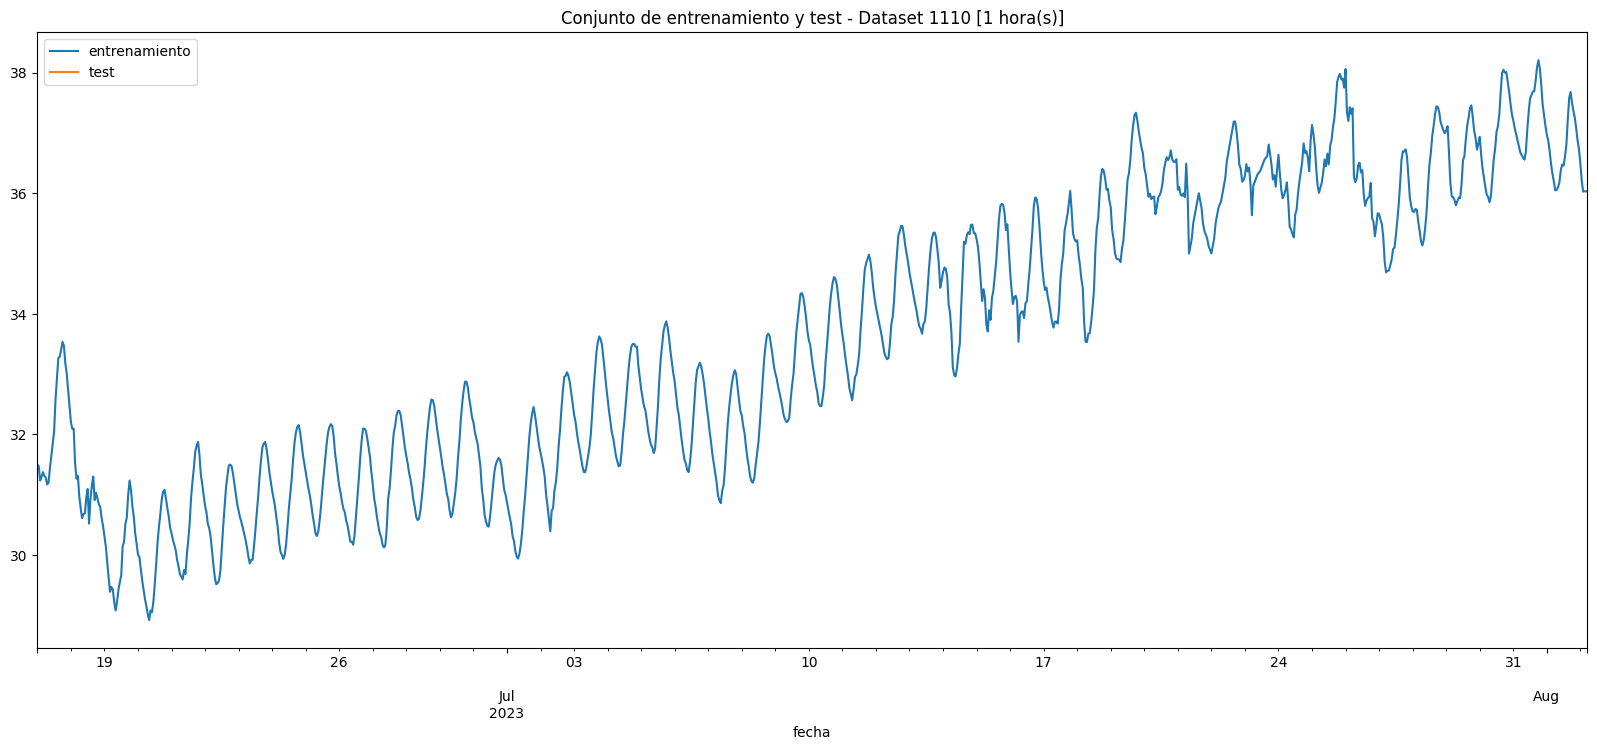

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


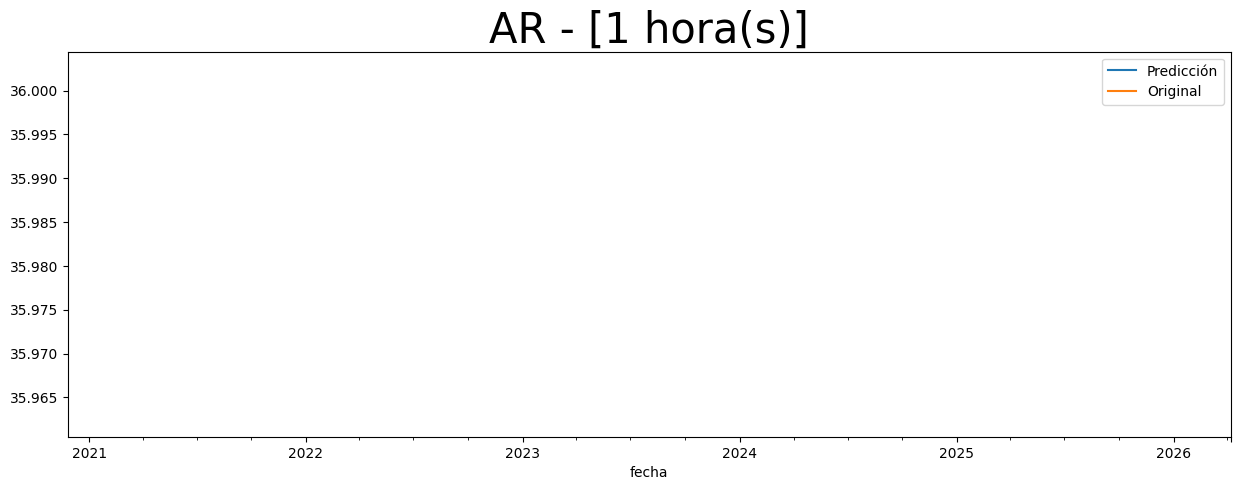

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


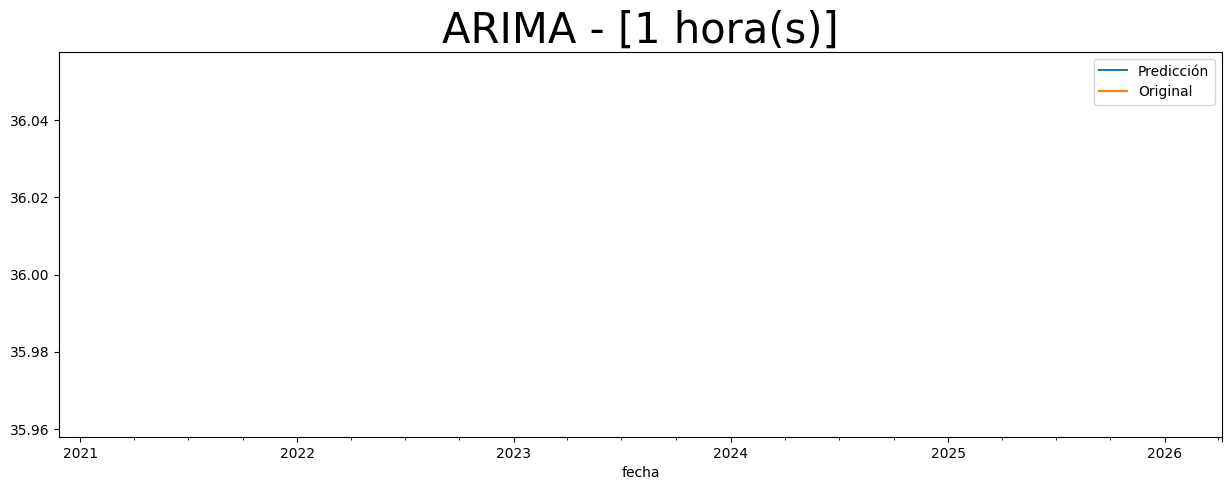

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


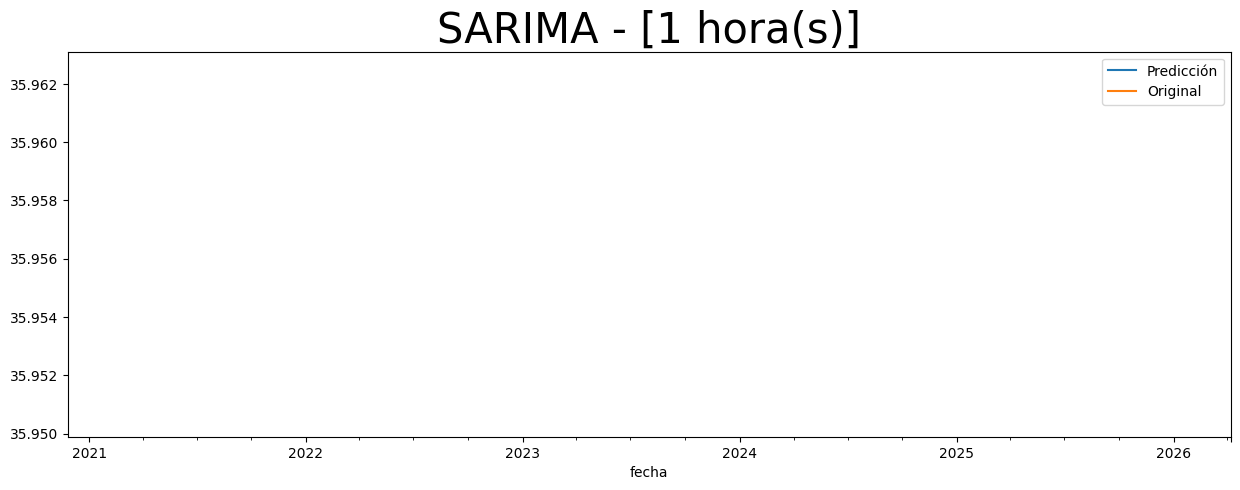

Fechas train : 2023-06-17 00:00:00 --- 2023-08-02 03:00:00  (n=1108)
Fechas test  : 2023-08-02 04:00:00 --- 2023-08-02 05:00:00  (n=2)


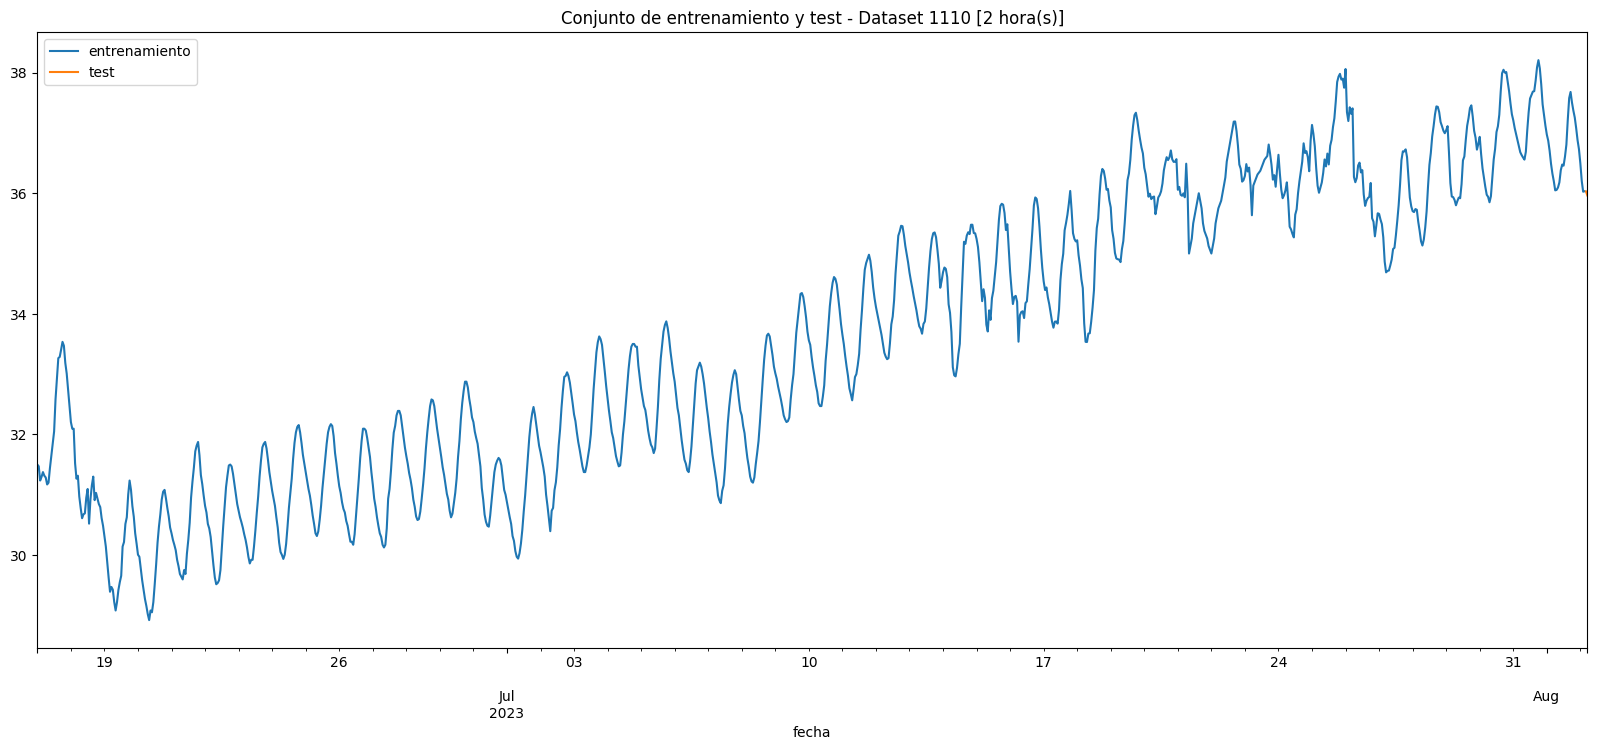

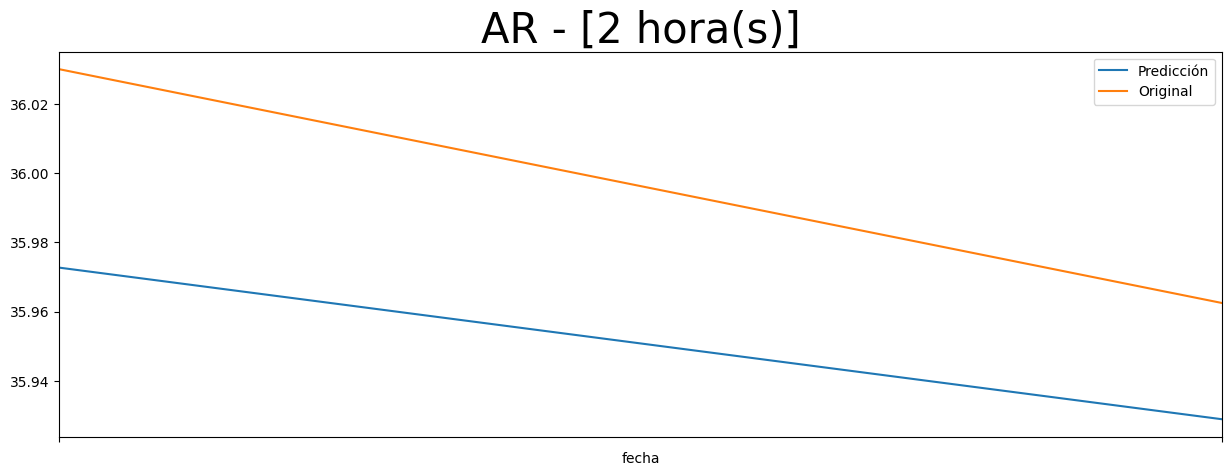

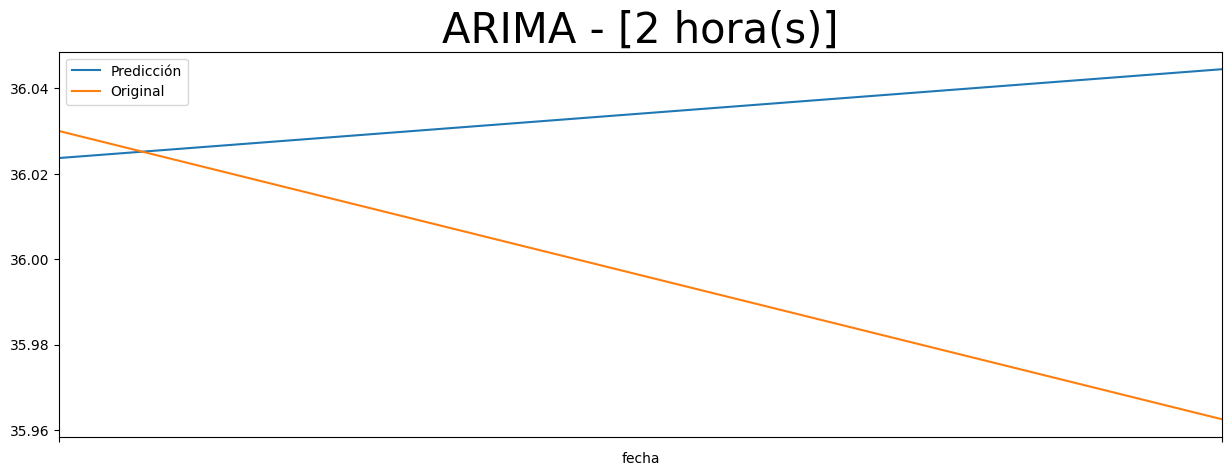

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


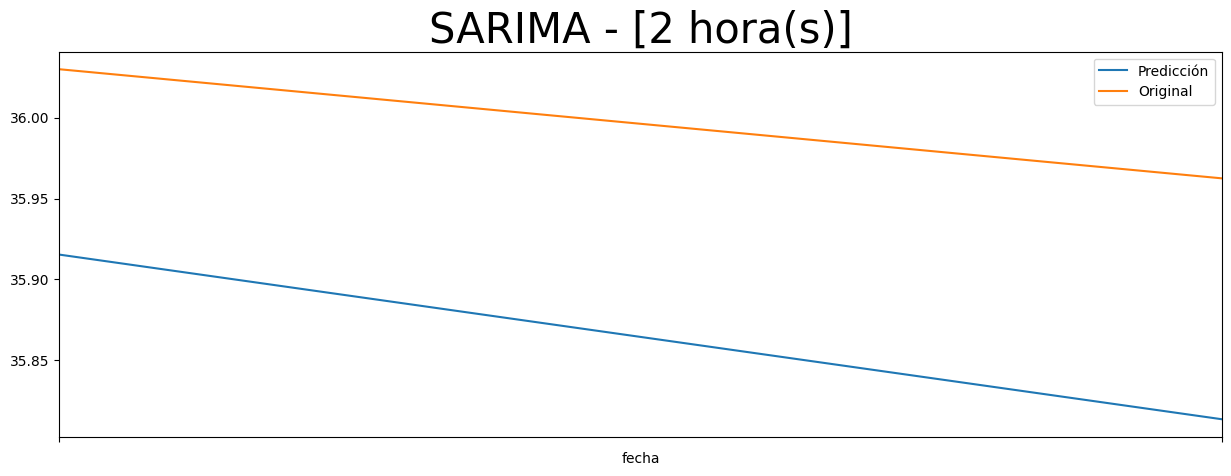

Fechas train : 2023-06-17 00:00:00 --- 2023-08-01 17:00:00  (n=1098)
Fechas test  : 2023-08-01 18:00:00 --- 2023-08-02 05:00:00  (n=12)


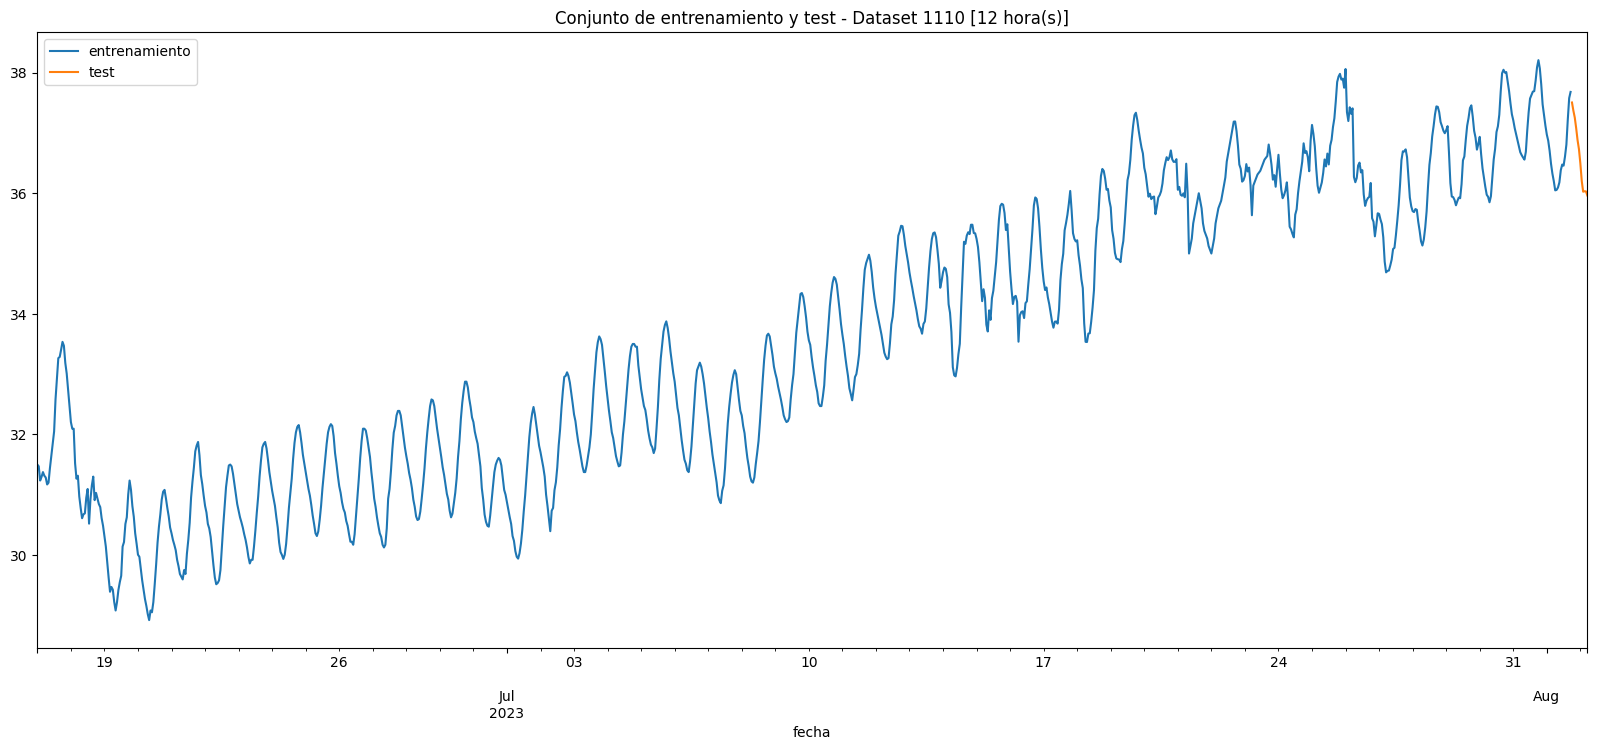

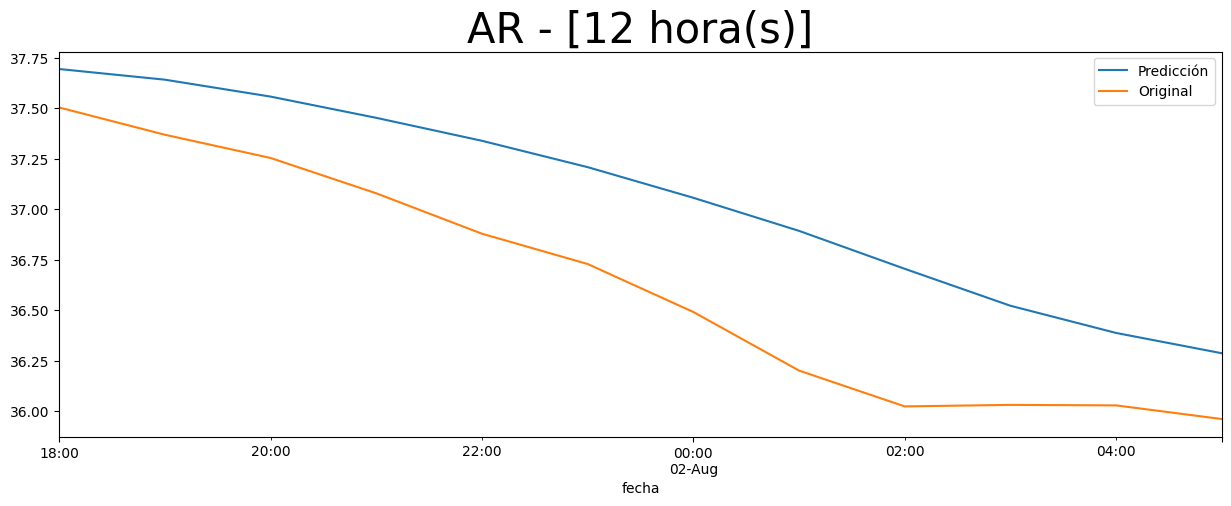

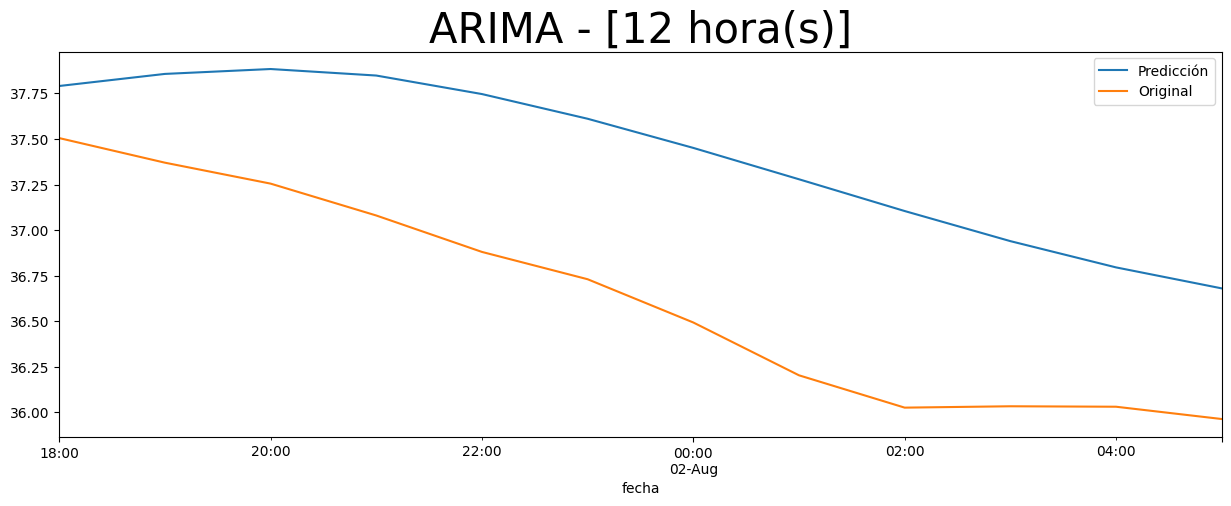

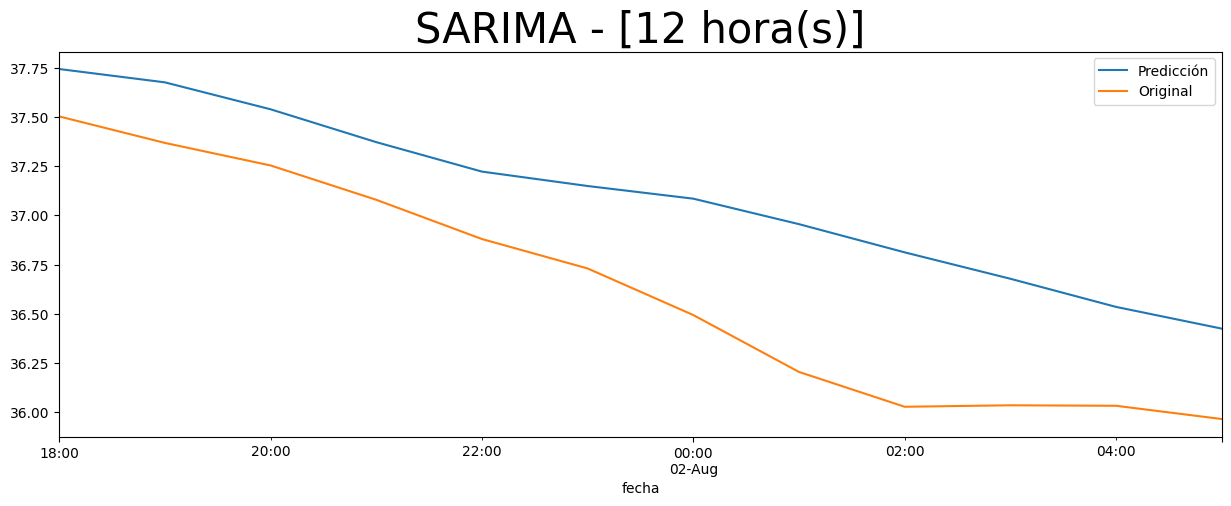

Fechas train : 2023-06-17 00:00:00 --- 2023-08-01 05:00:00  (n=1086)
Fechas test  : 2023-08-01 06:00:00 --- 2023-08-02 05:00:00  (n=24)


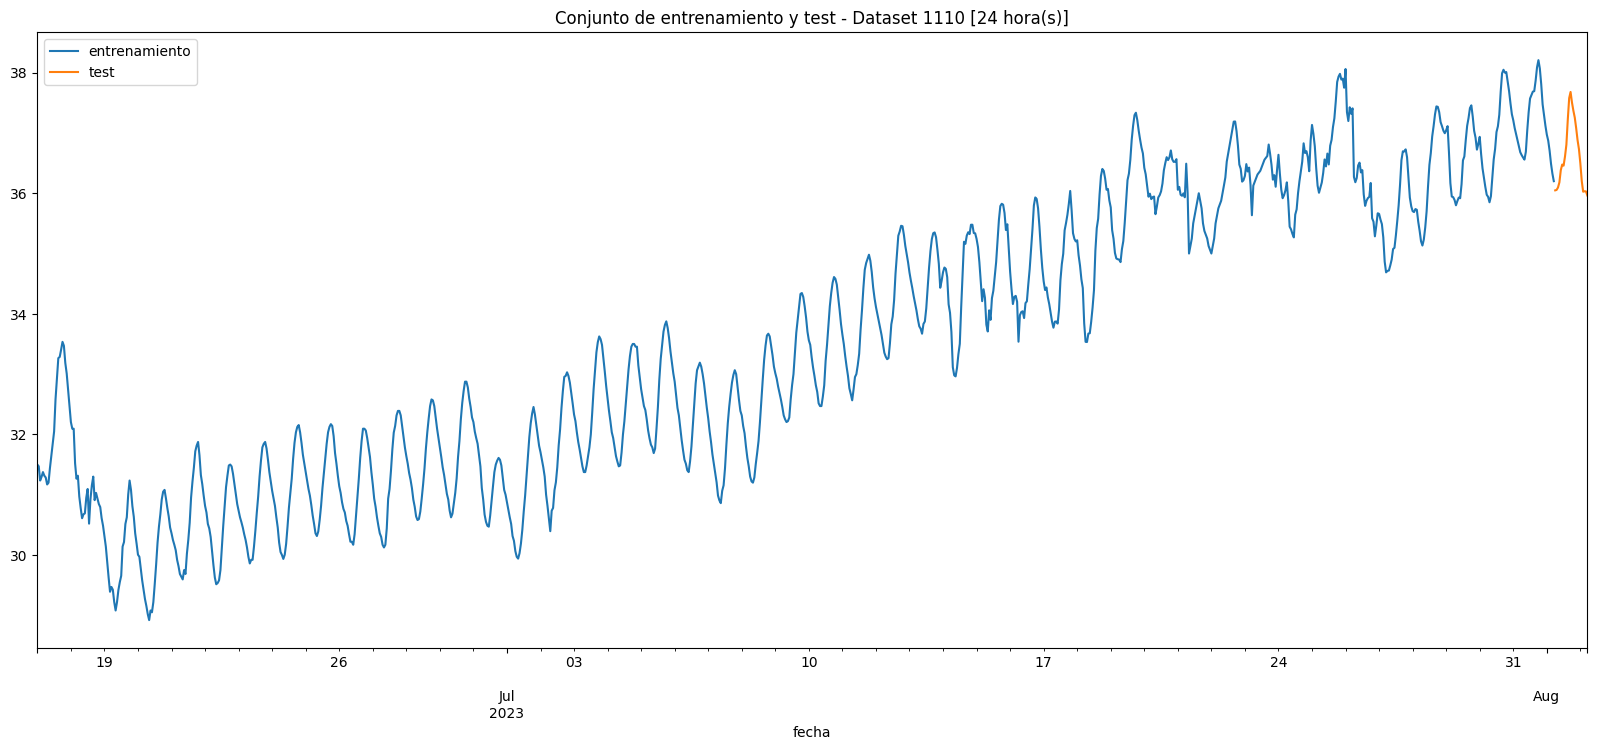

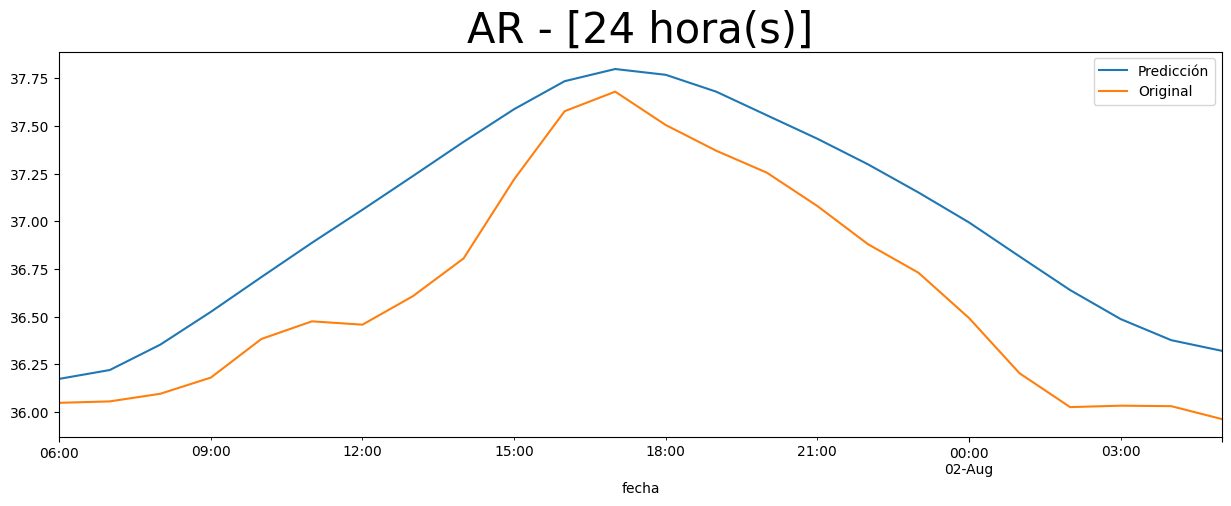

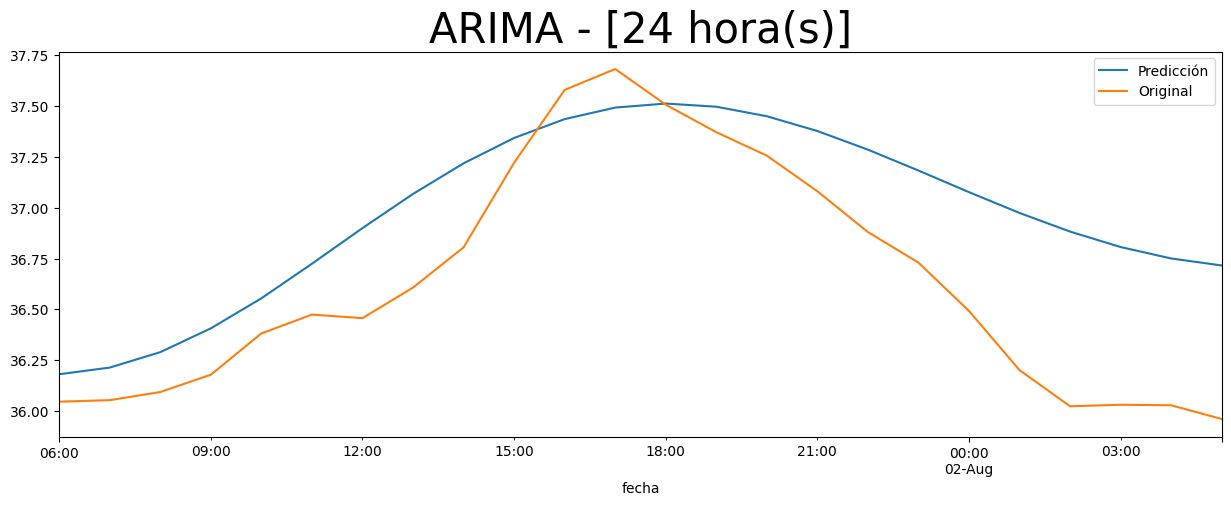

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


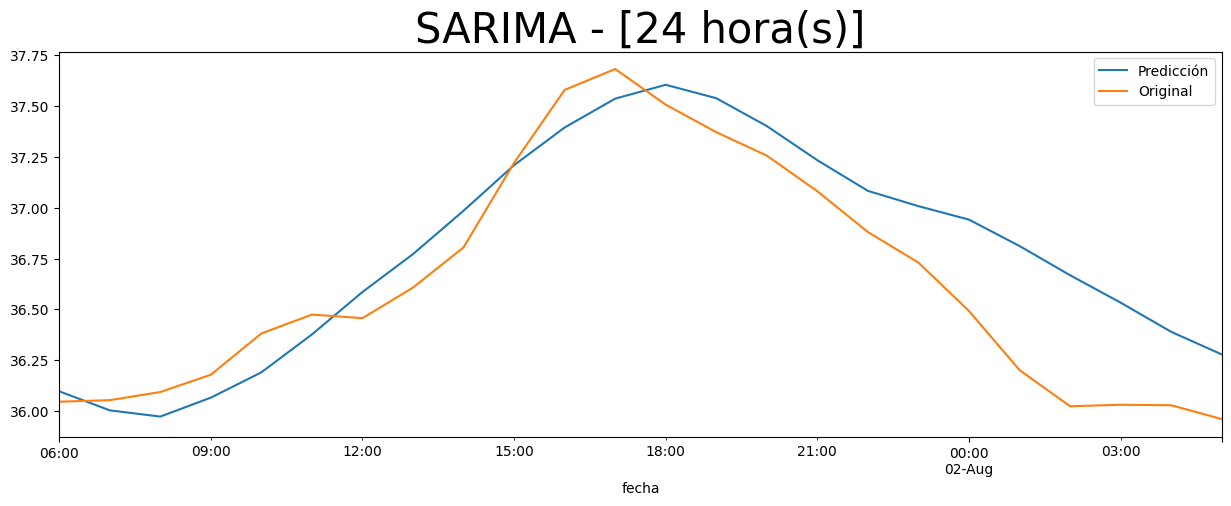

Fechas train : 2023-06-17 00:00:00 --- 2023-07-31 05:00:00  (n=1062)
Fechas test  : 2023-07-31 06:00:00 --- 2023-08-02 05:00:00  (n=48)


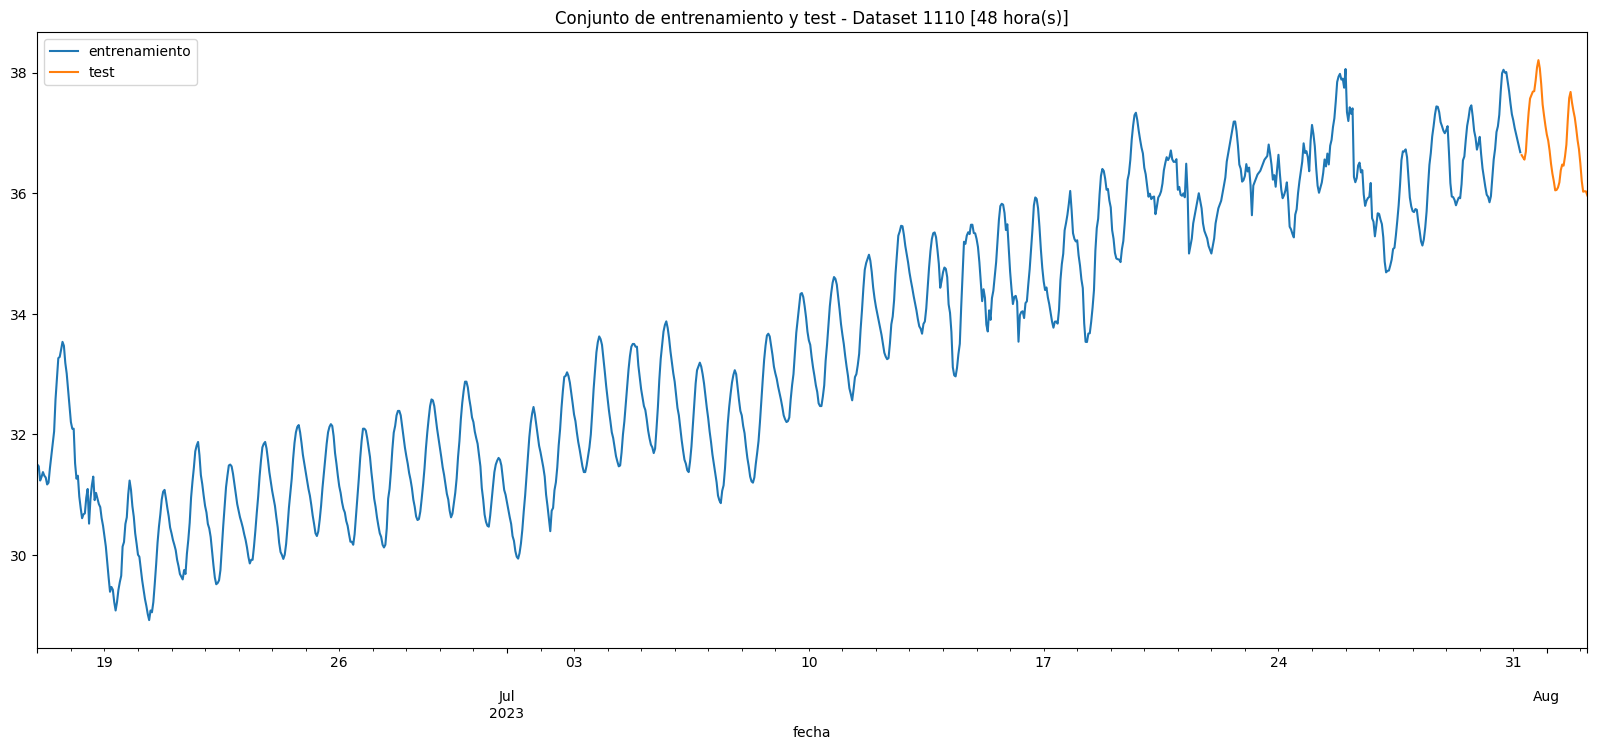

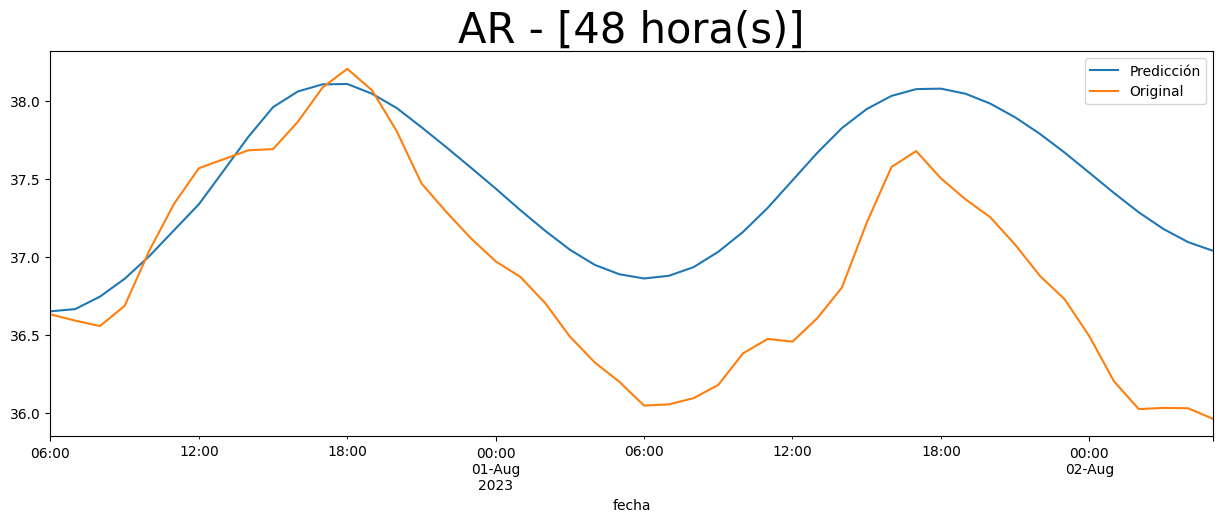

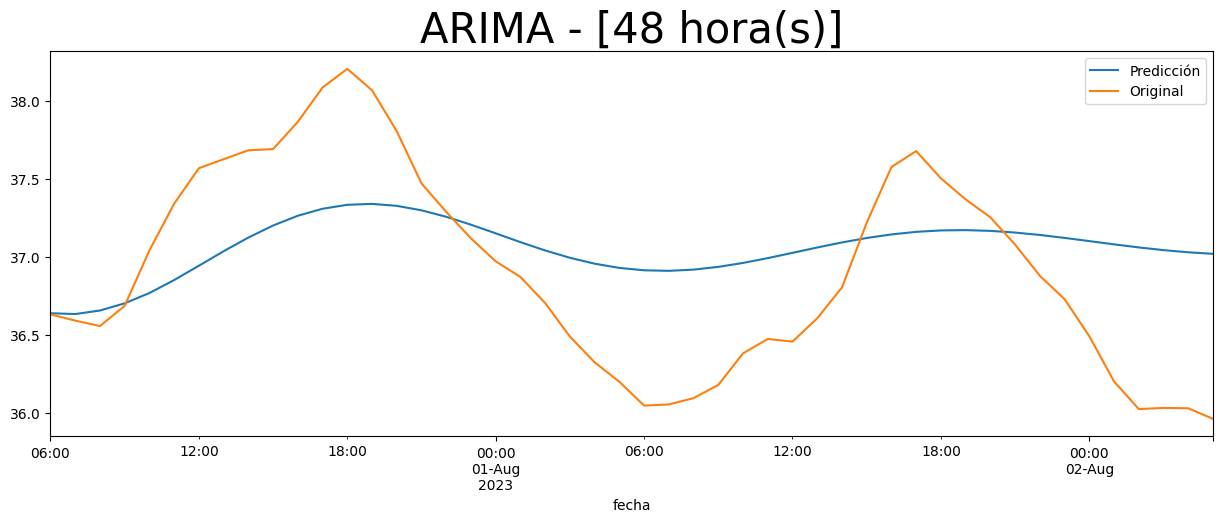

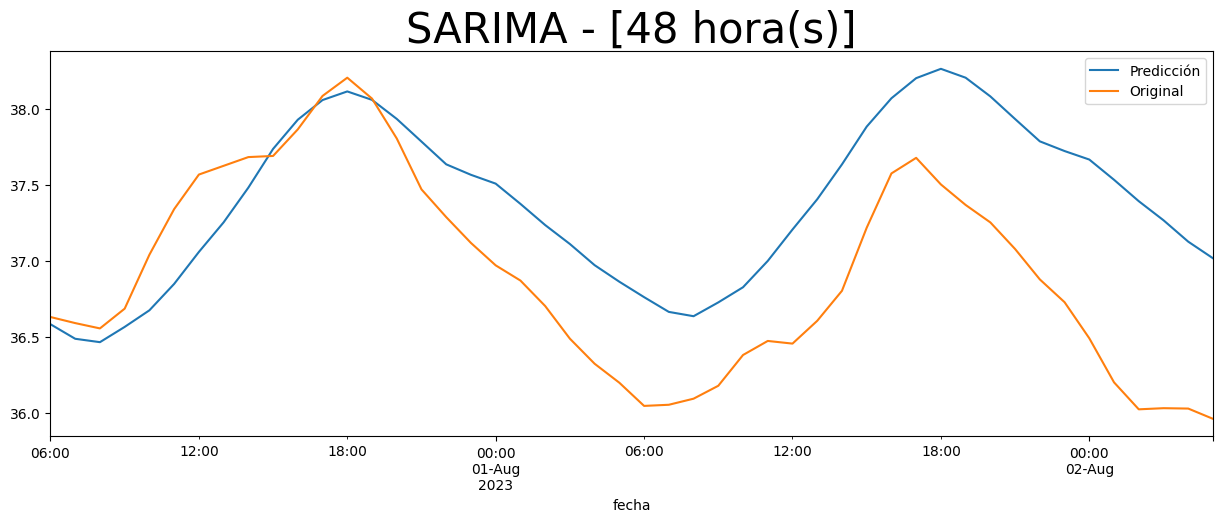

Fechas train : 2023-06-17 00:00:00 --- 2023-07-28 05:00:00  (n=990)
Fechas test  : 2023-07-28 06:00:00 --- 2023-08-02 05:00:00  (n=120)


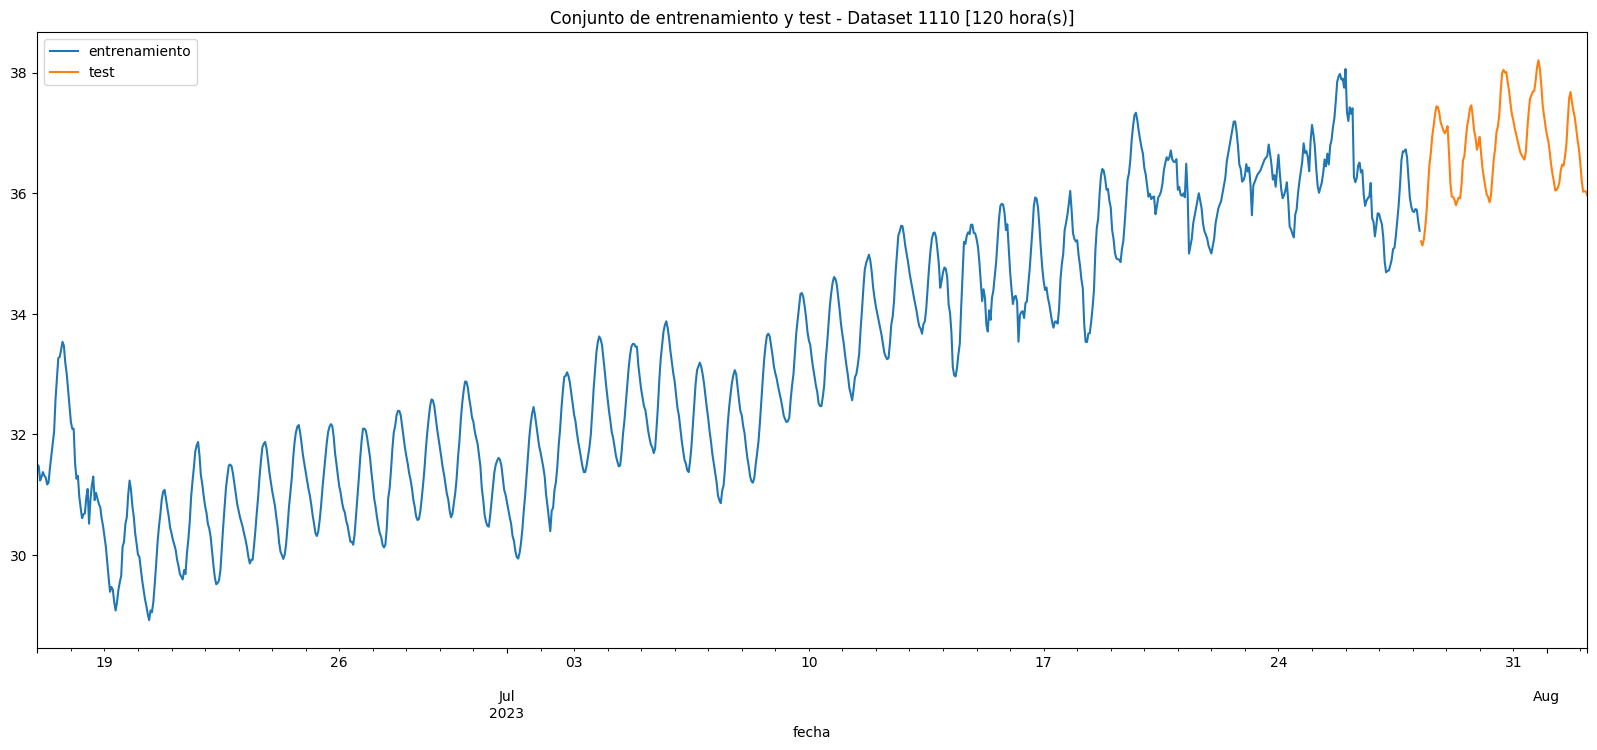

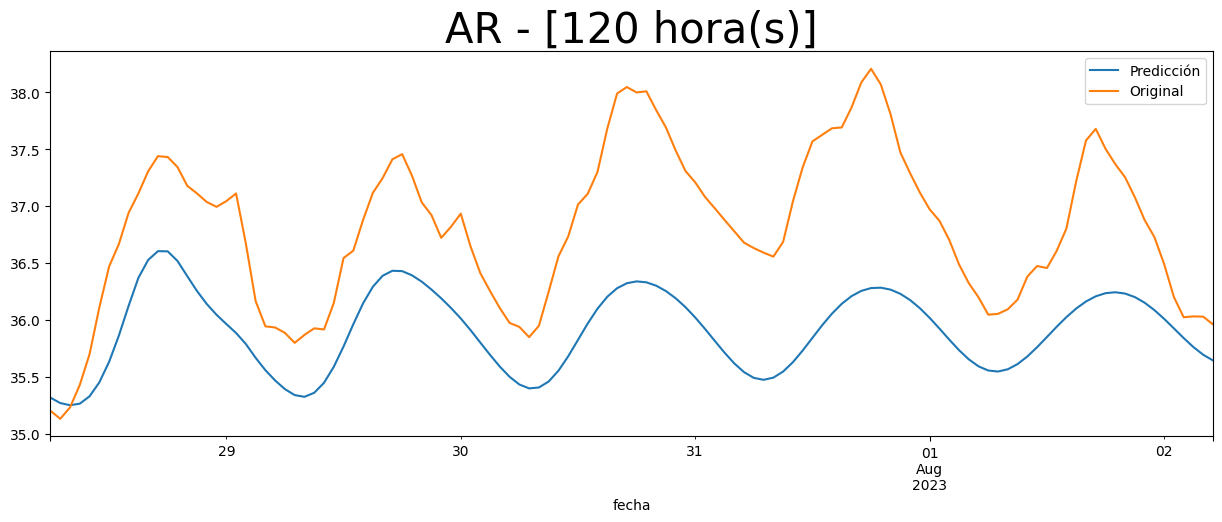

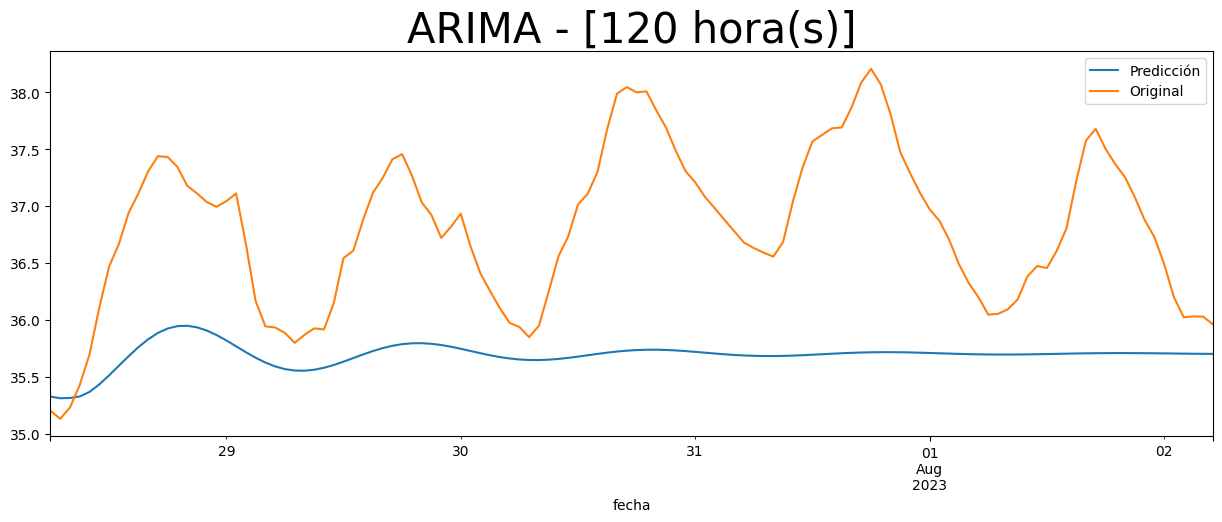

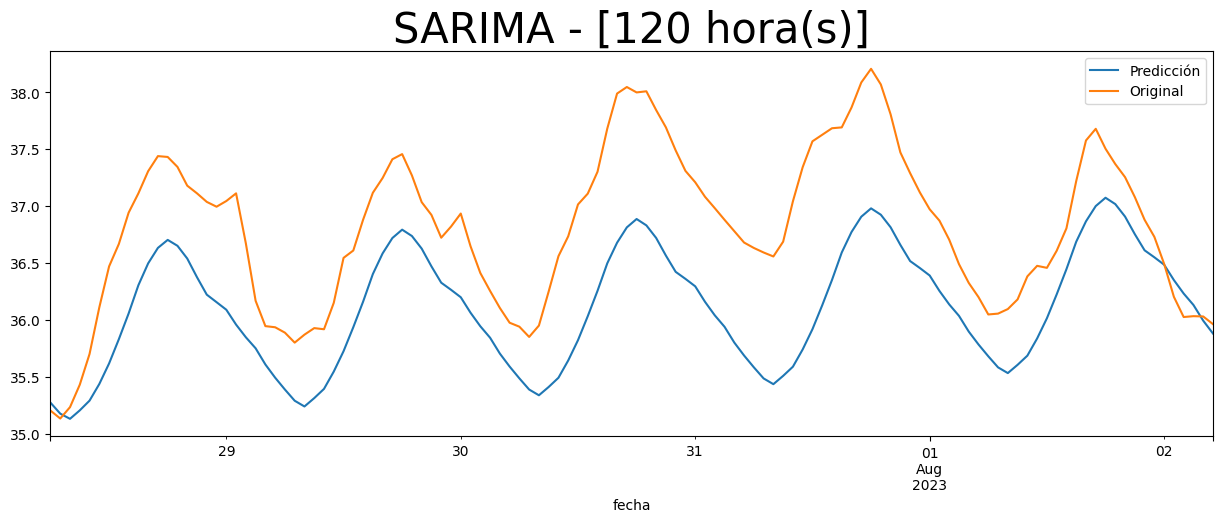

Fechas train : 2023-06-17 00:00:00 --- 2023-07-23 05:00:00  (n=870)
Fechas test  : 2023-07-23 06:00:00 --- 2023-08-02 05:00:00  (n=240)


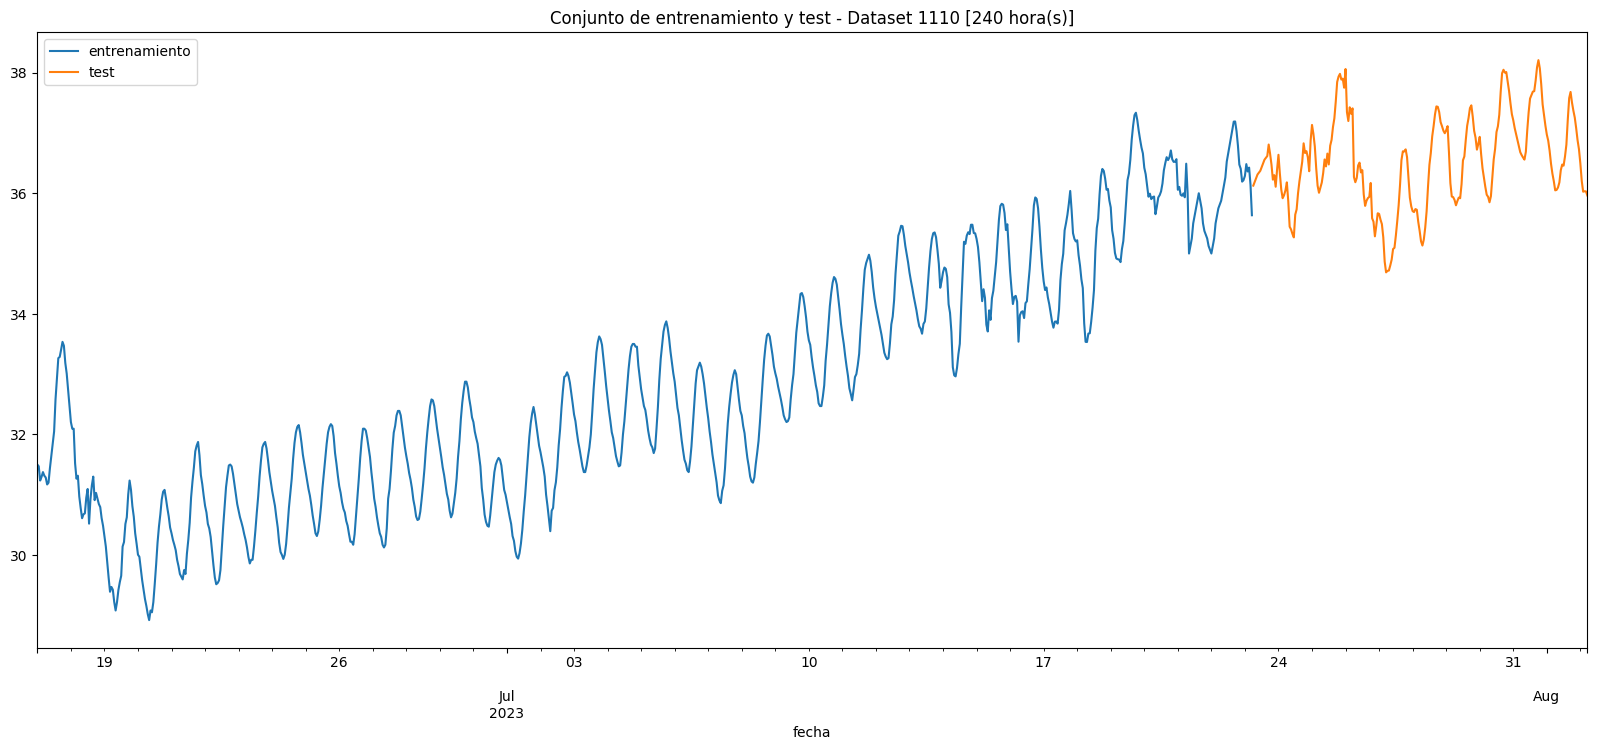

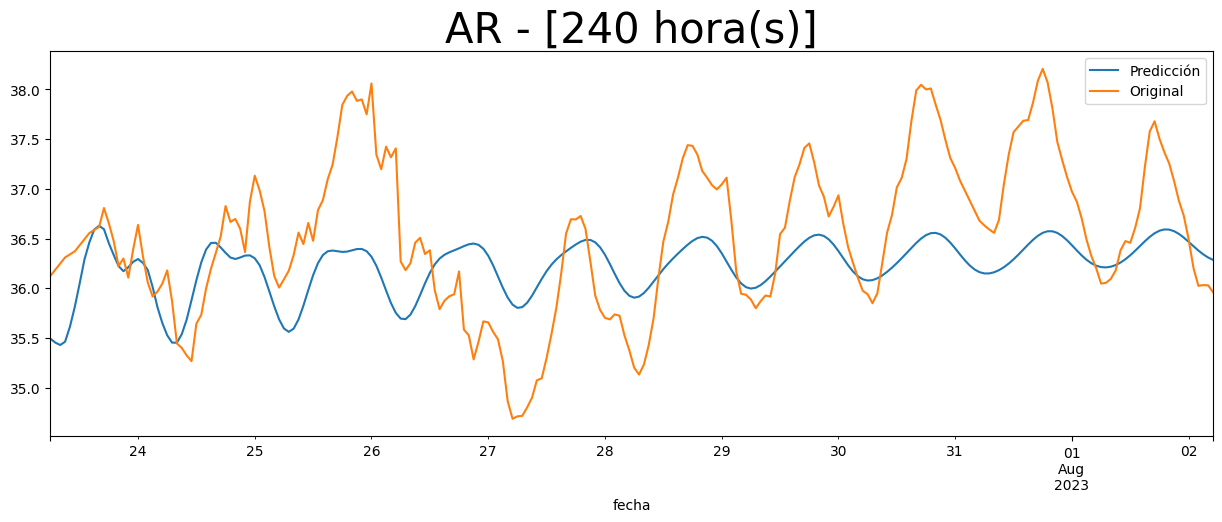

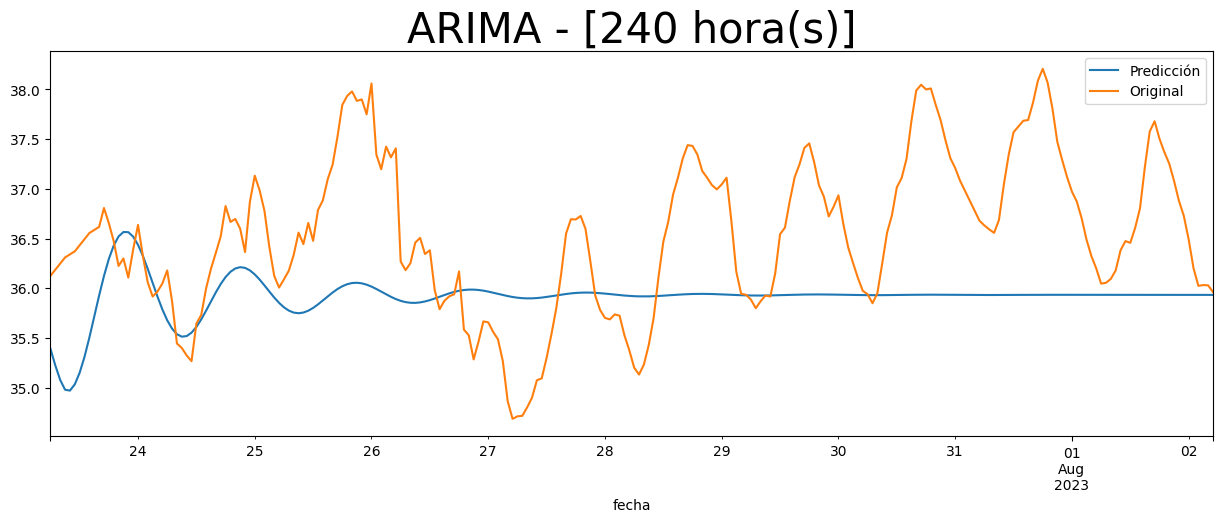

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


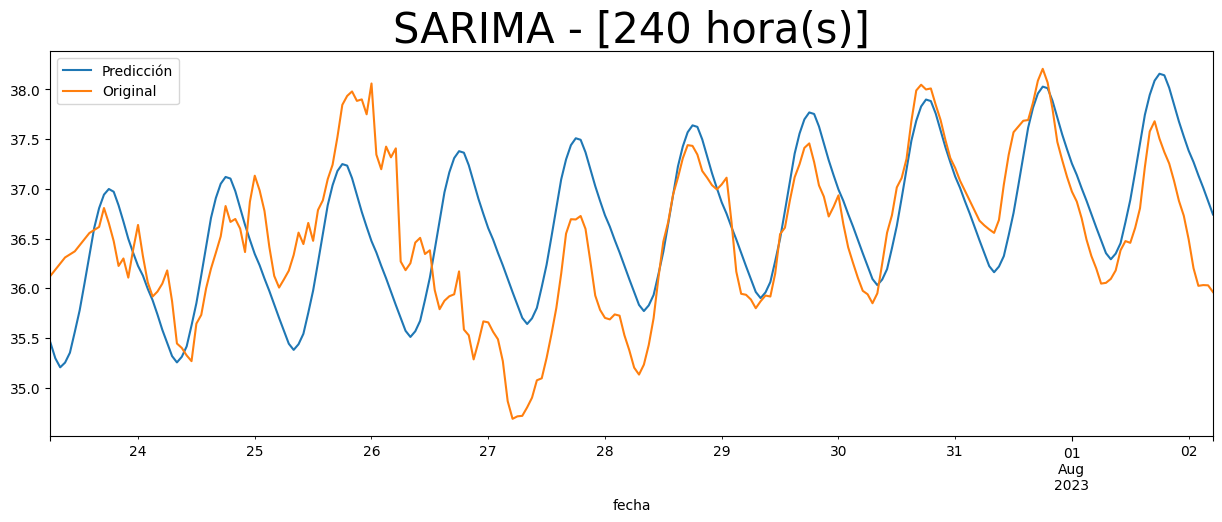

Fechas train : 2023-06-17 00:00:00 --- 2023-08-18 10:00:00  (n=1499)
Fechas test  : 2023-08-18 11:00:00 --- 2023-08-18 11:00:00  (n=1)


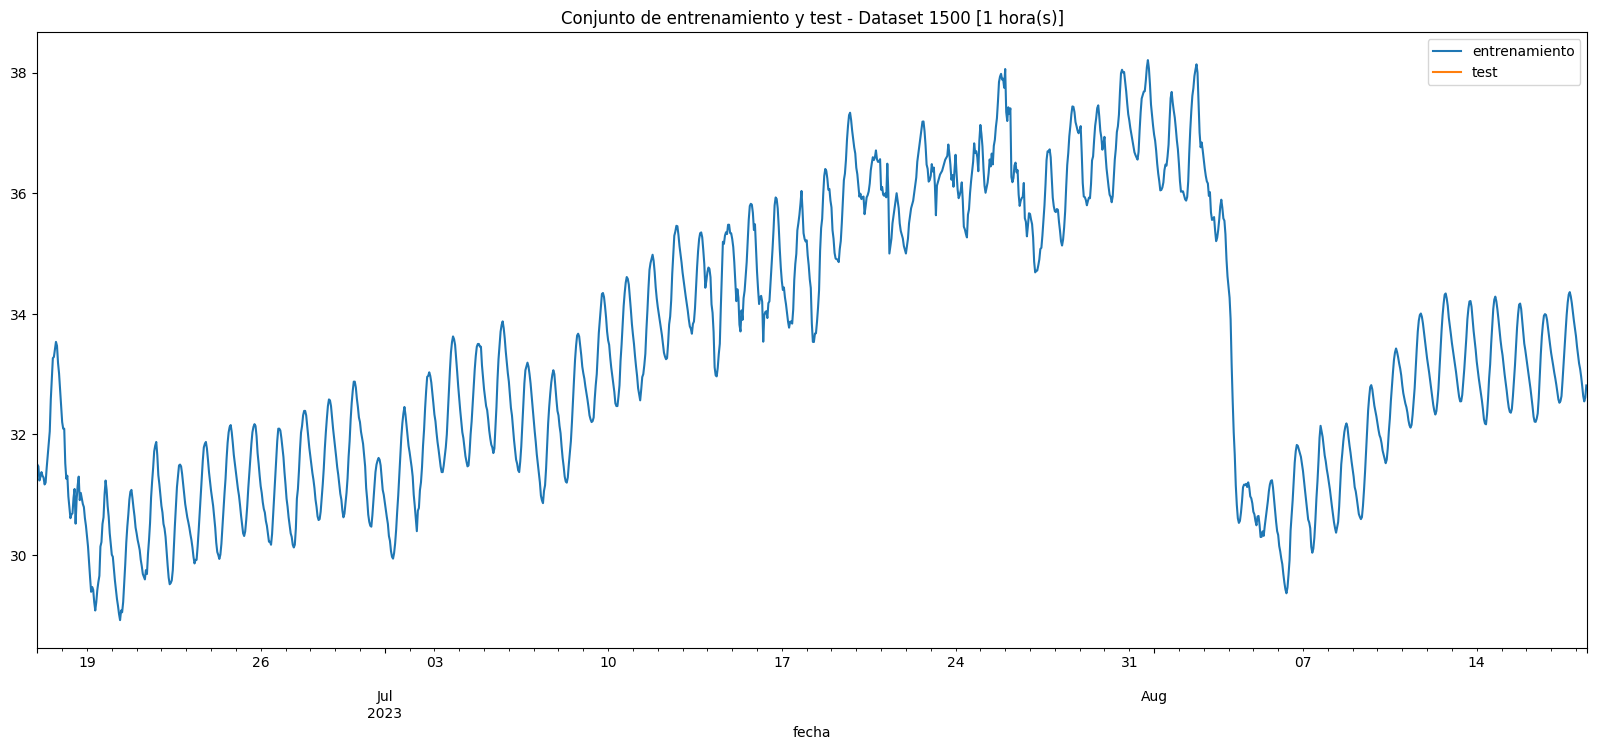

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


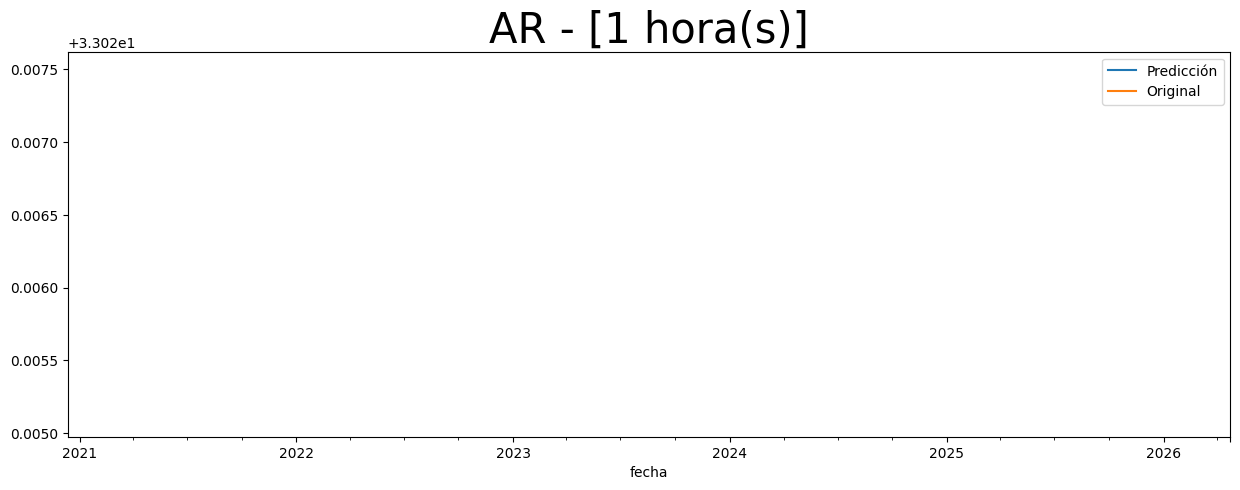

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


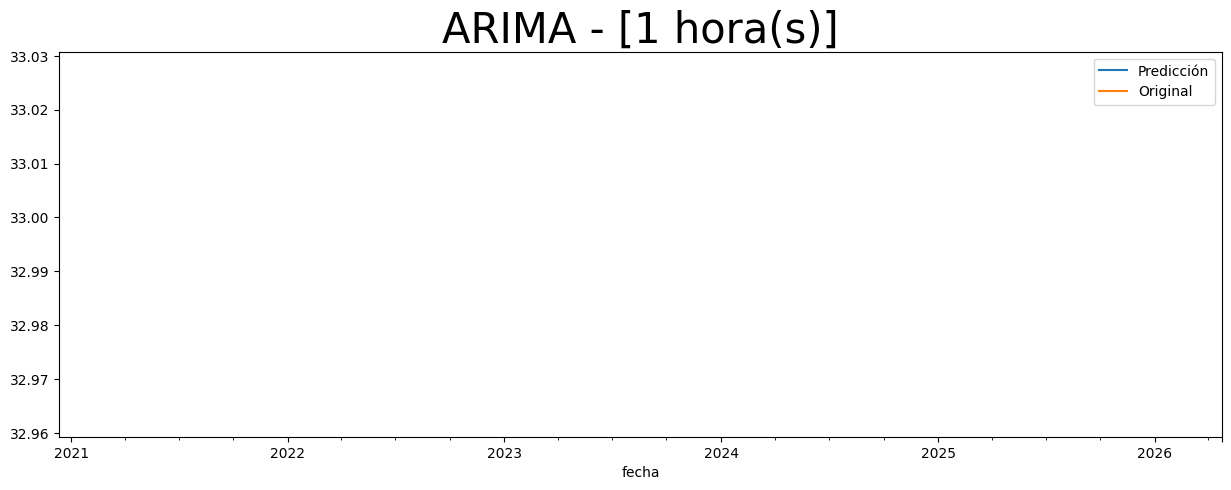

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\plotting\_matplotlib\core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)


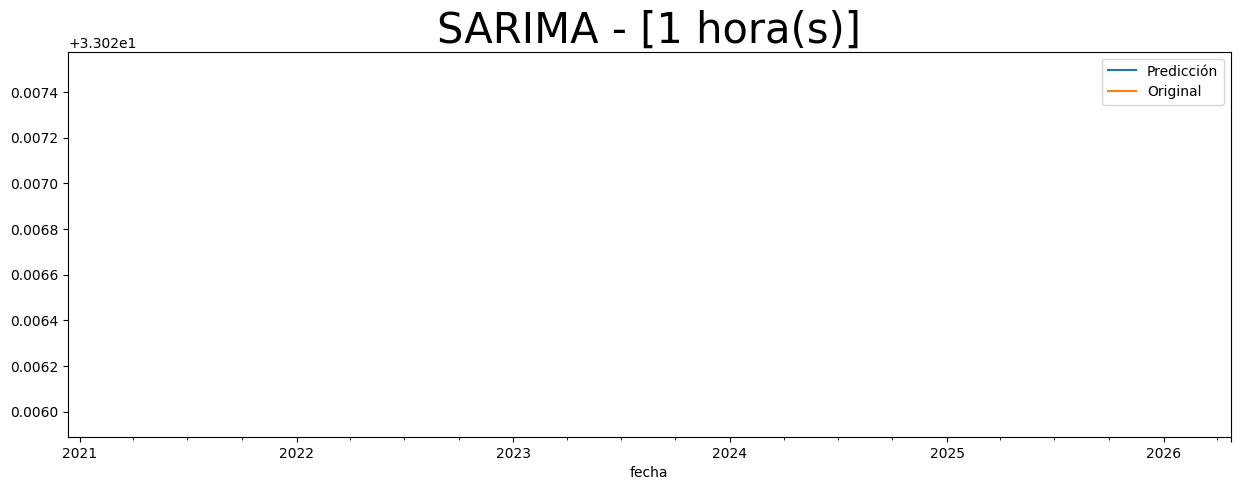

Fechas train : 2023-06-17 00:00:00 --- 2023-08-18 09:00:00  (n=1498)
Fechas test  : 2023-08-18 10:00:00 --- 2023-08-18 11:00:00  (n=2)


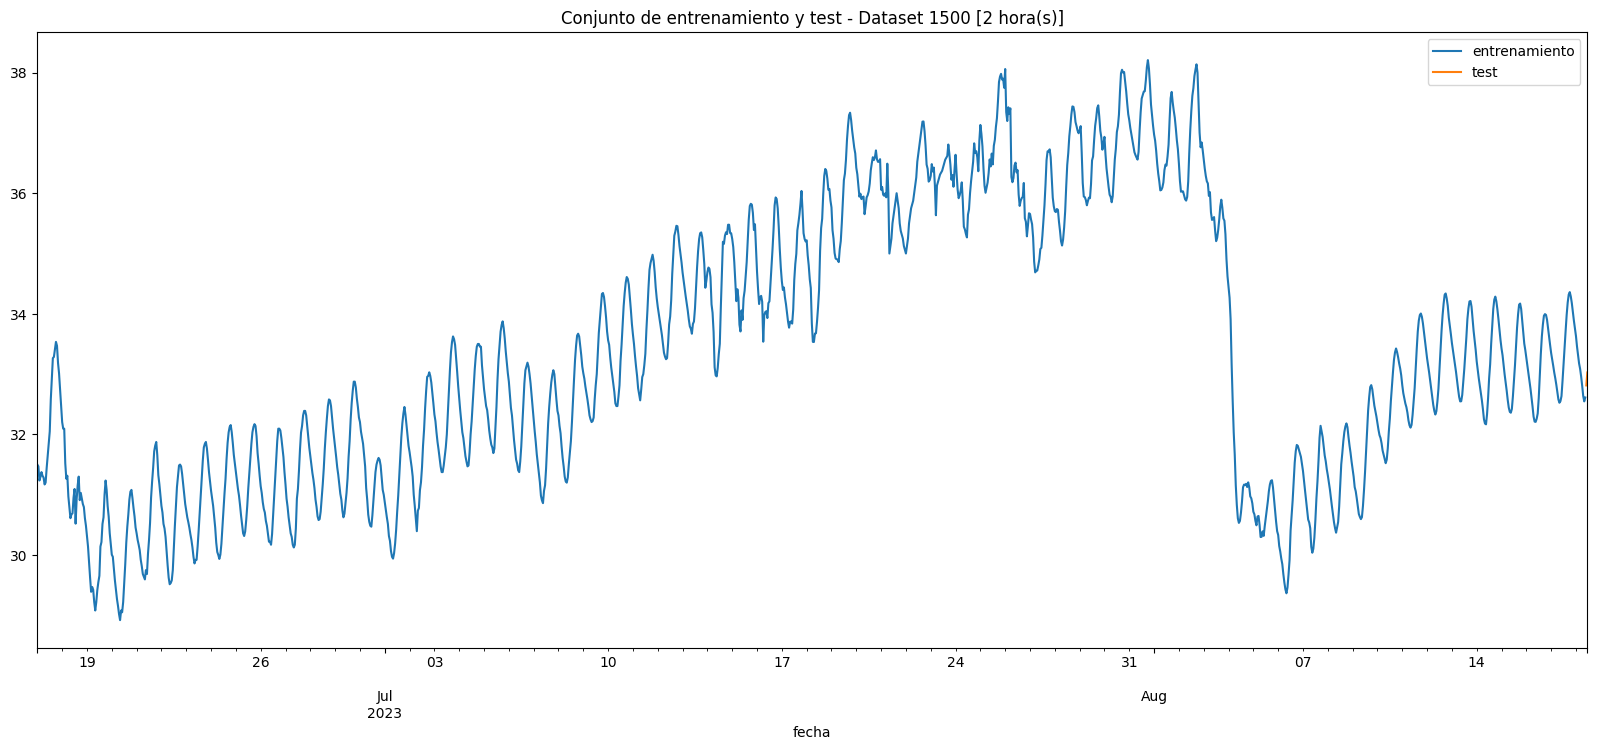

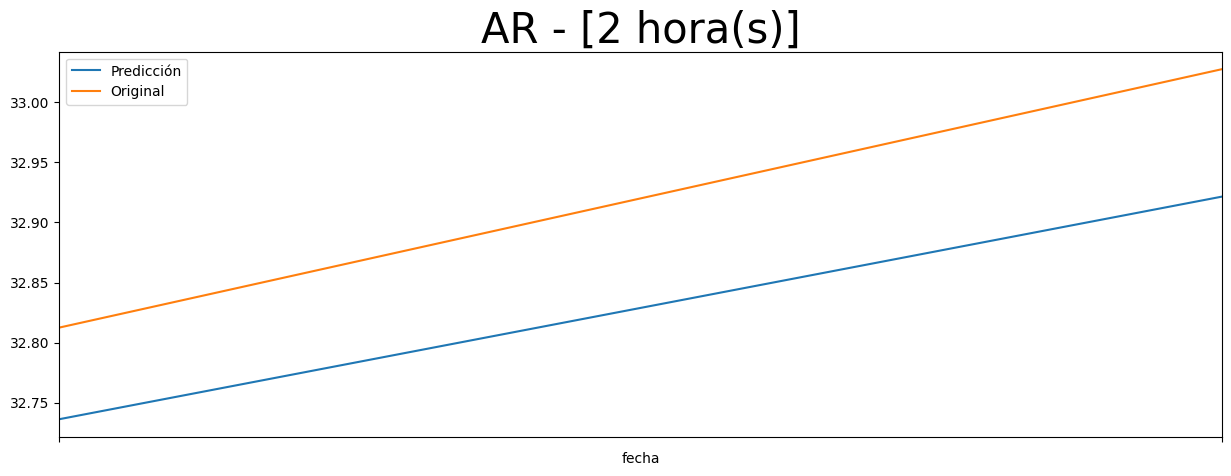

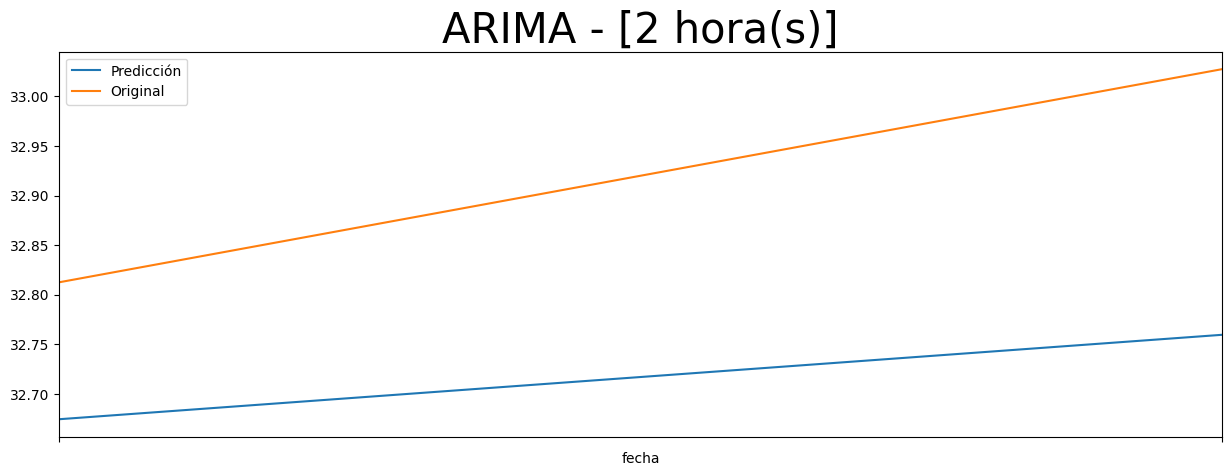

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


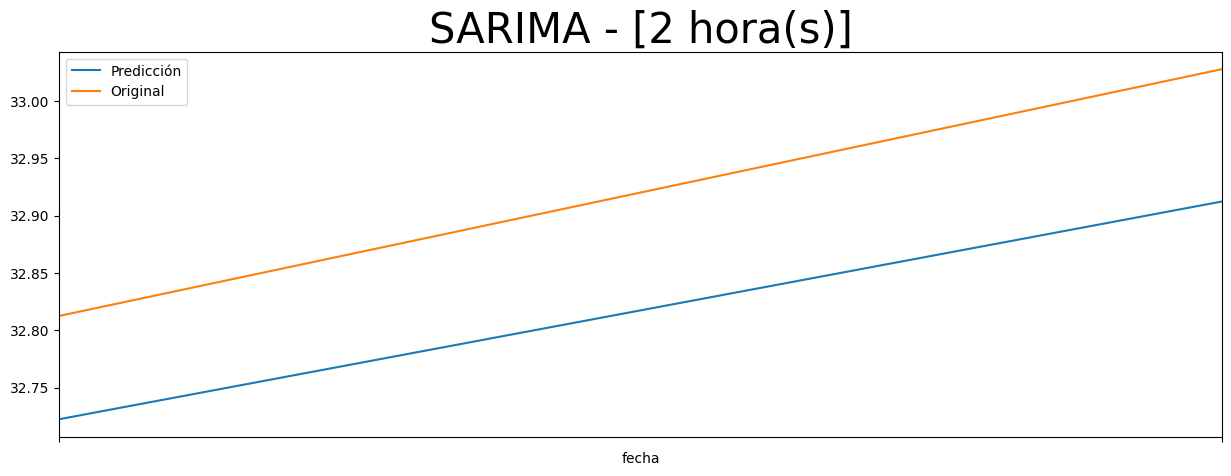

Fechas train : 2023-06-17 00:00:00 --- 2023-08-17 23:00:00  (n=1488)
Fechas test  : 2023-08-18 00:00:00 --- 2023-08-18 11:00:00  (n=12)


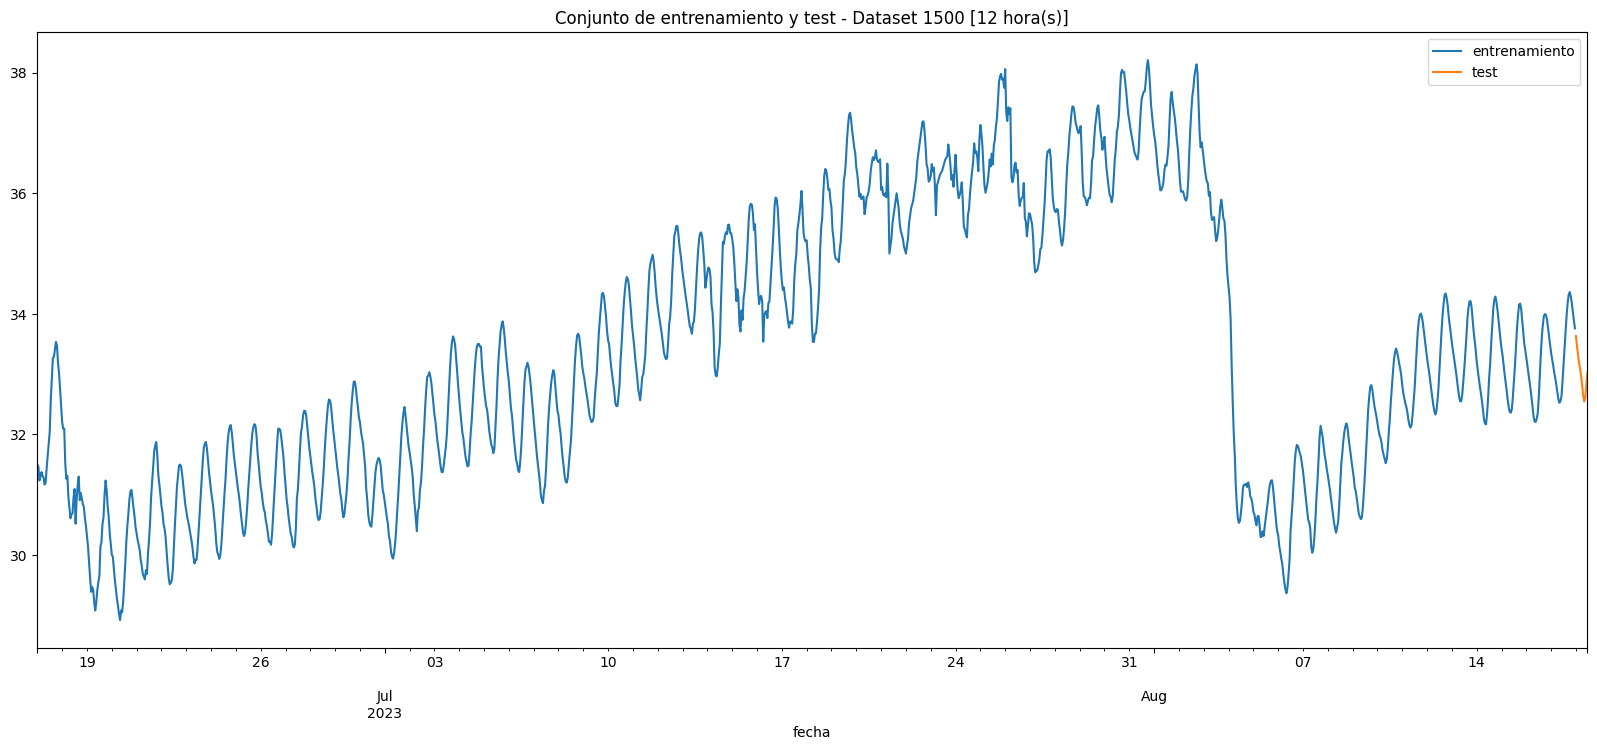

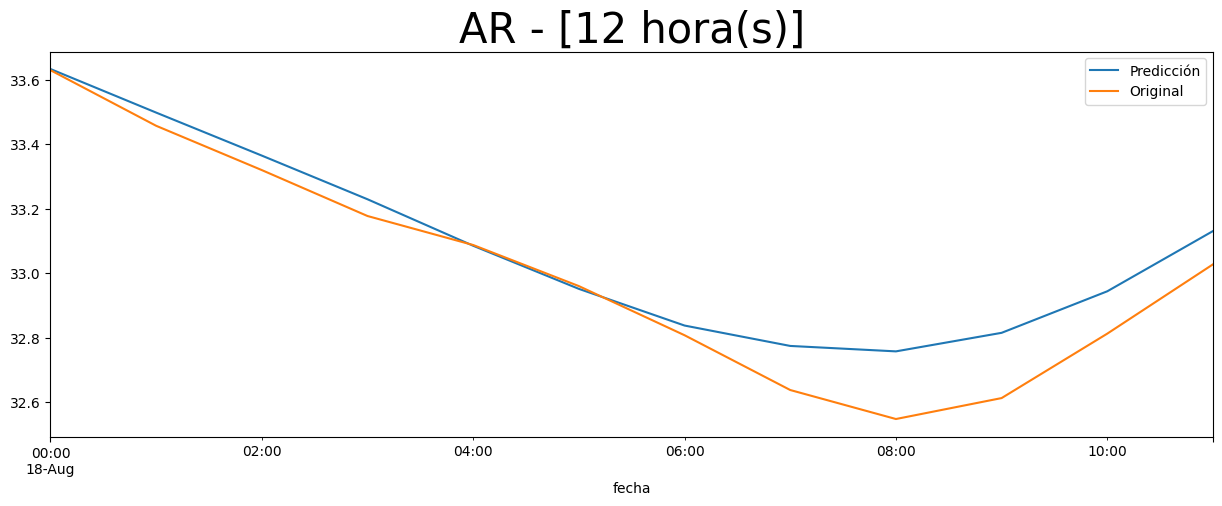

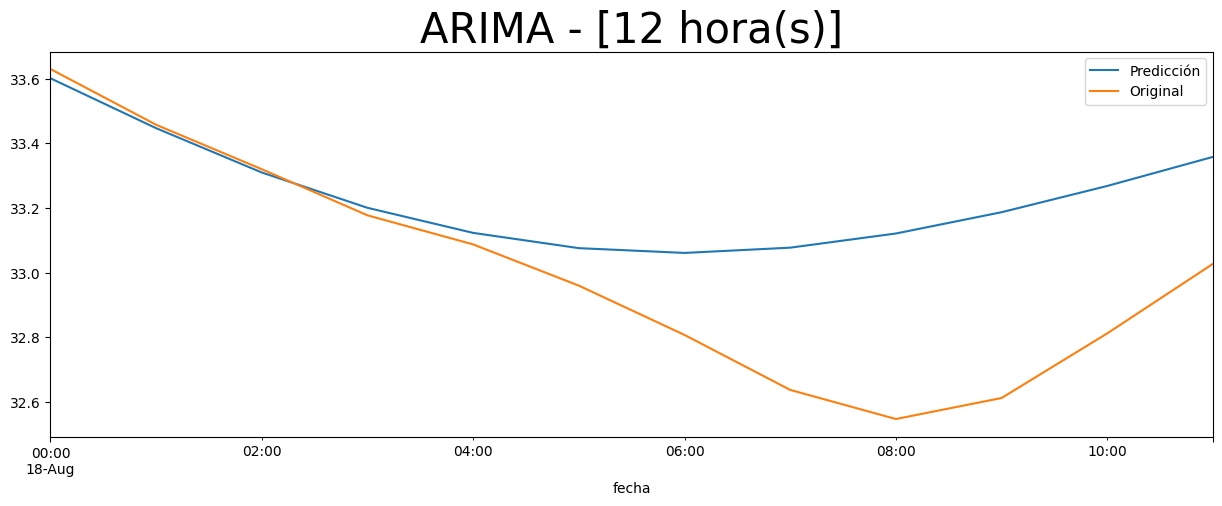

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


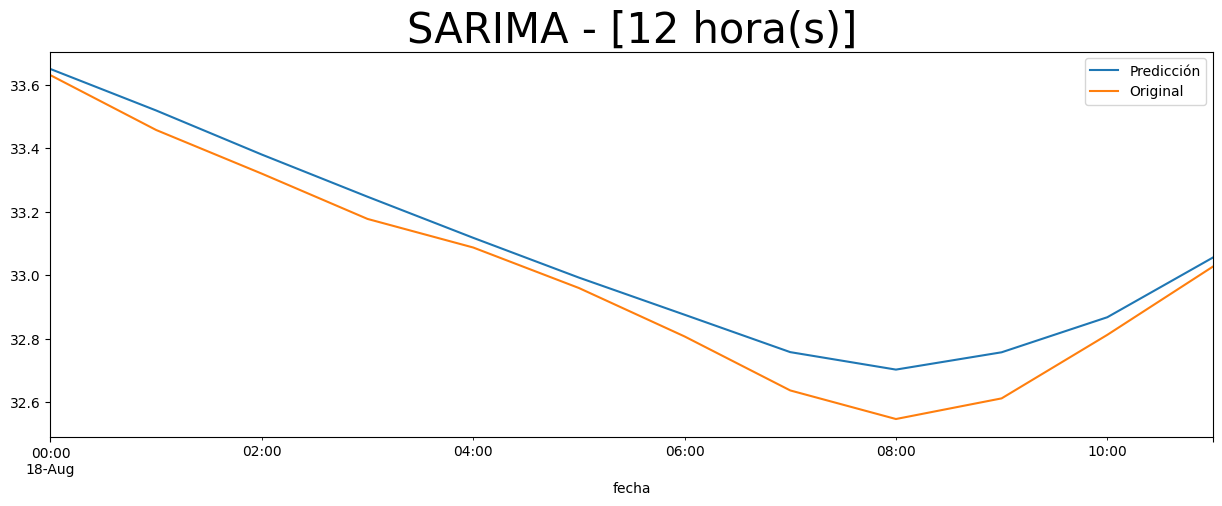

Fechas train : 2023-06-17 00:00:00 --- 2023-08-17 11:00:00  (n=1476)
Fechas test  : 2023-08-17 12:00:00 --- 2023-08-18 11:00:00  (n=24)


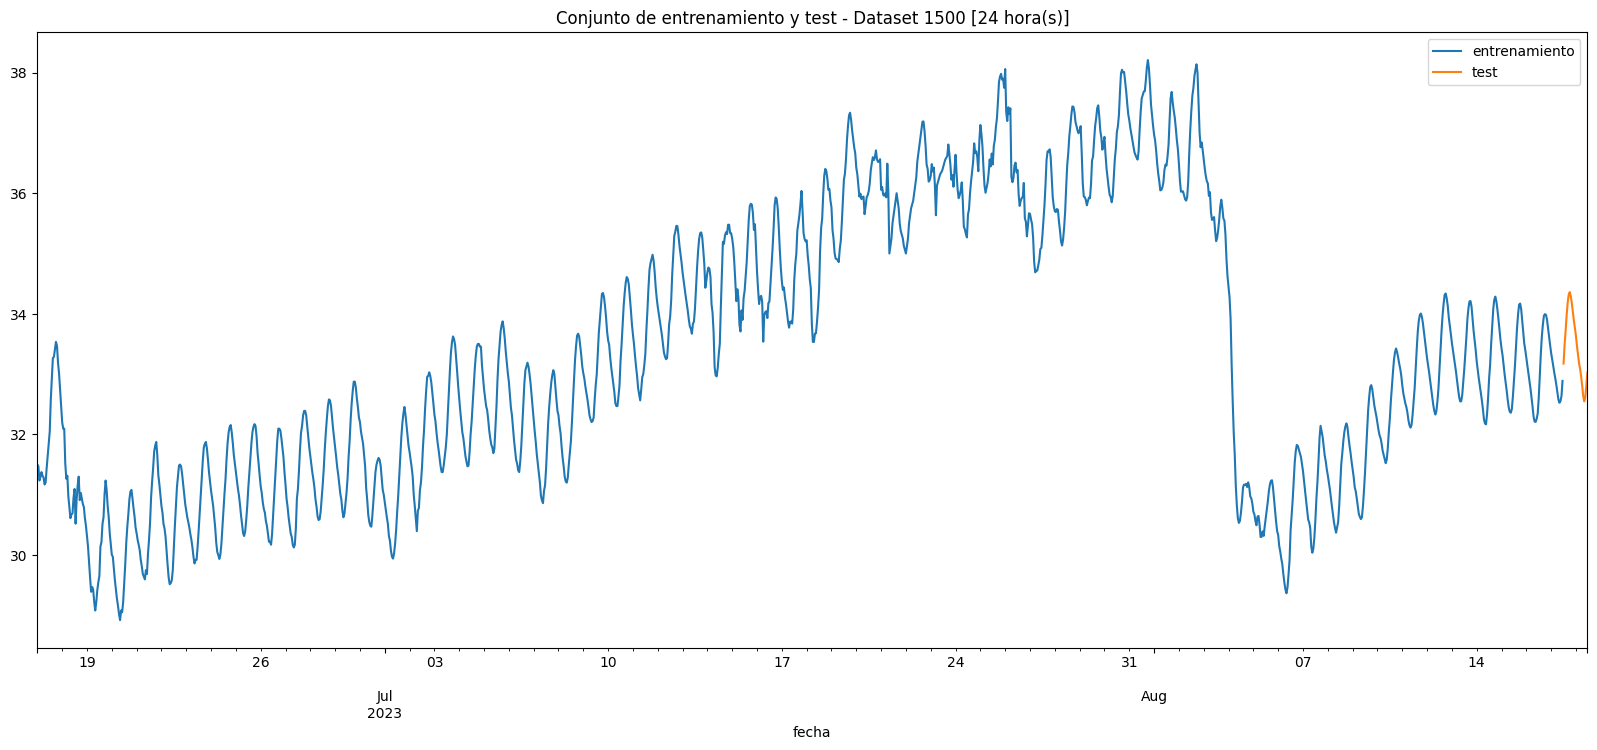

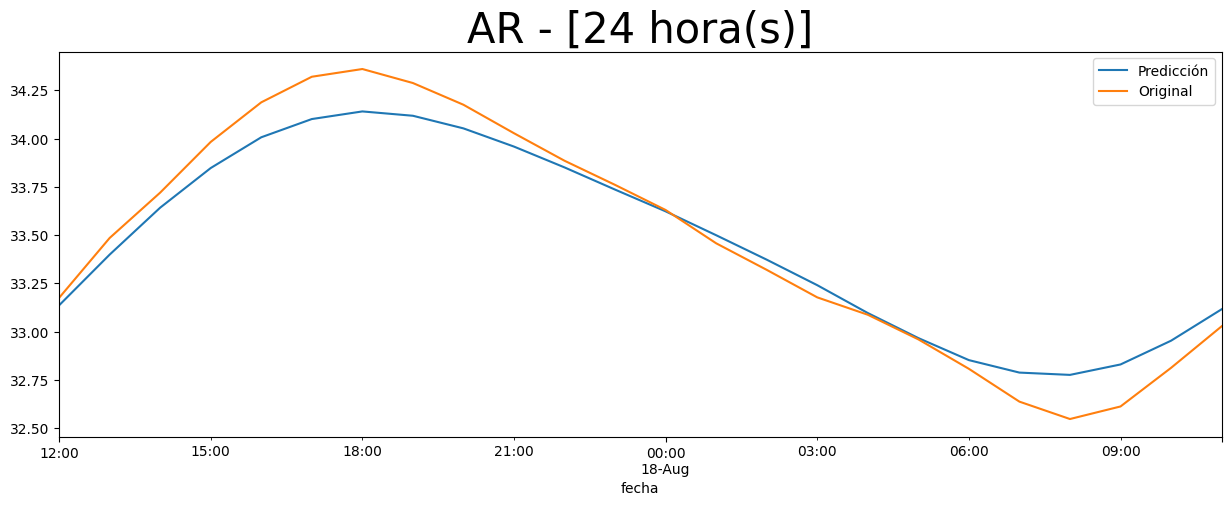

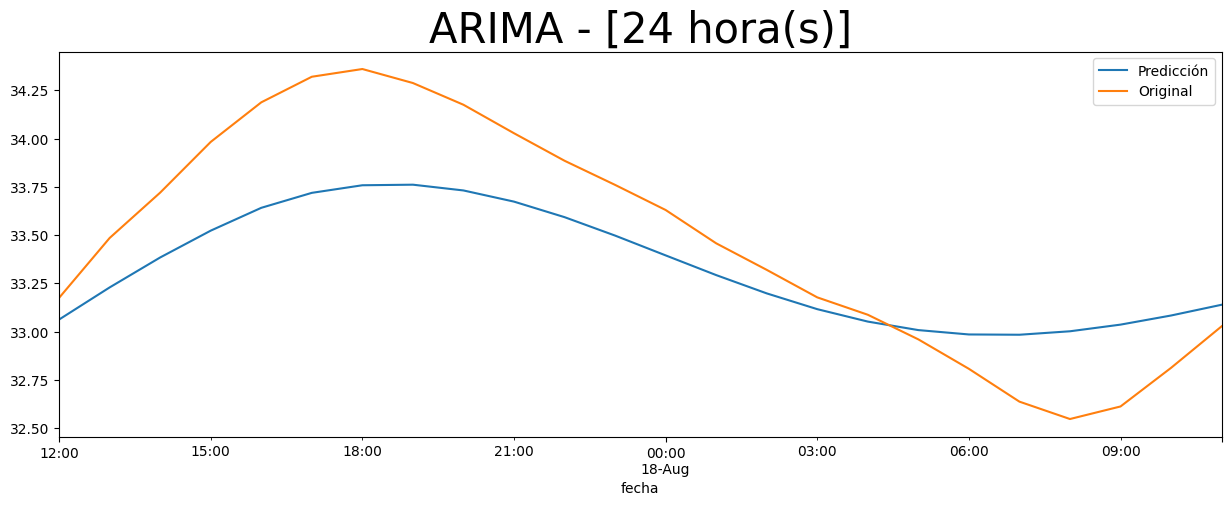

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


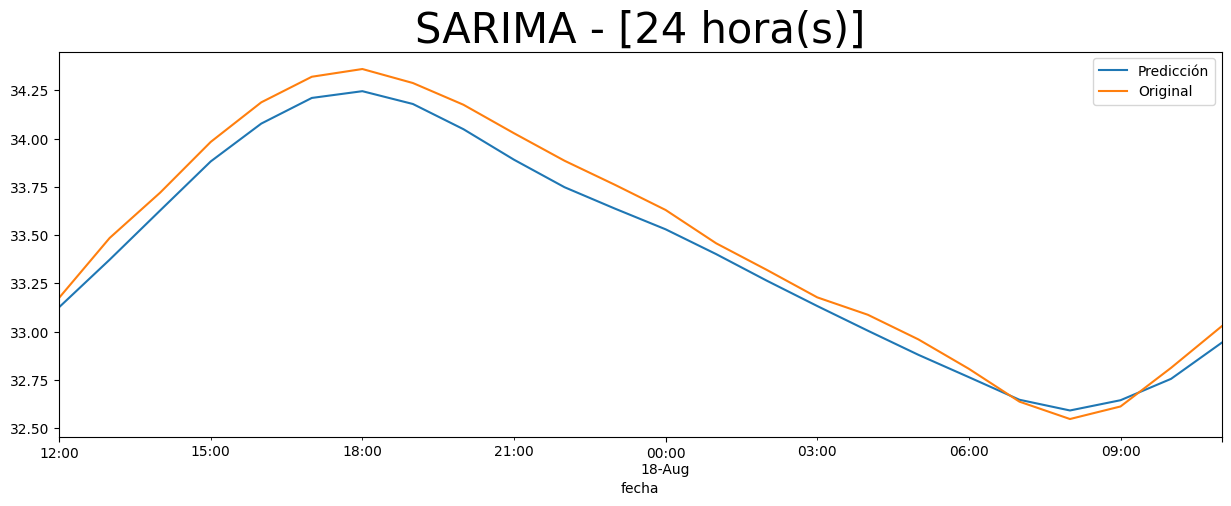

Fechas train : 2023-06-17 00:00:00 --- 2023-08-16 11:00:00  (n=1452)
Fechas test  : 2023-08-16 12:00:00 --- 2023-08-18 11:00:00  (n=48)


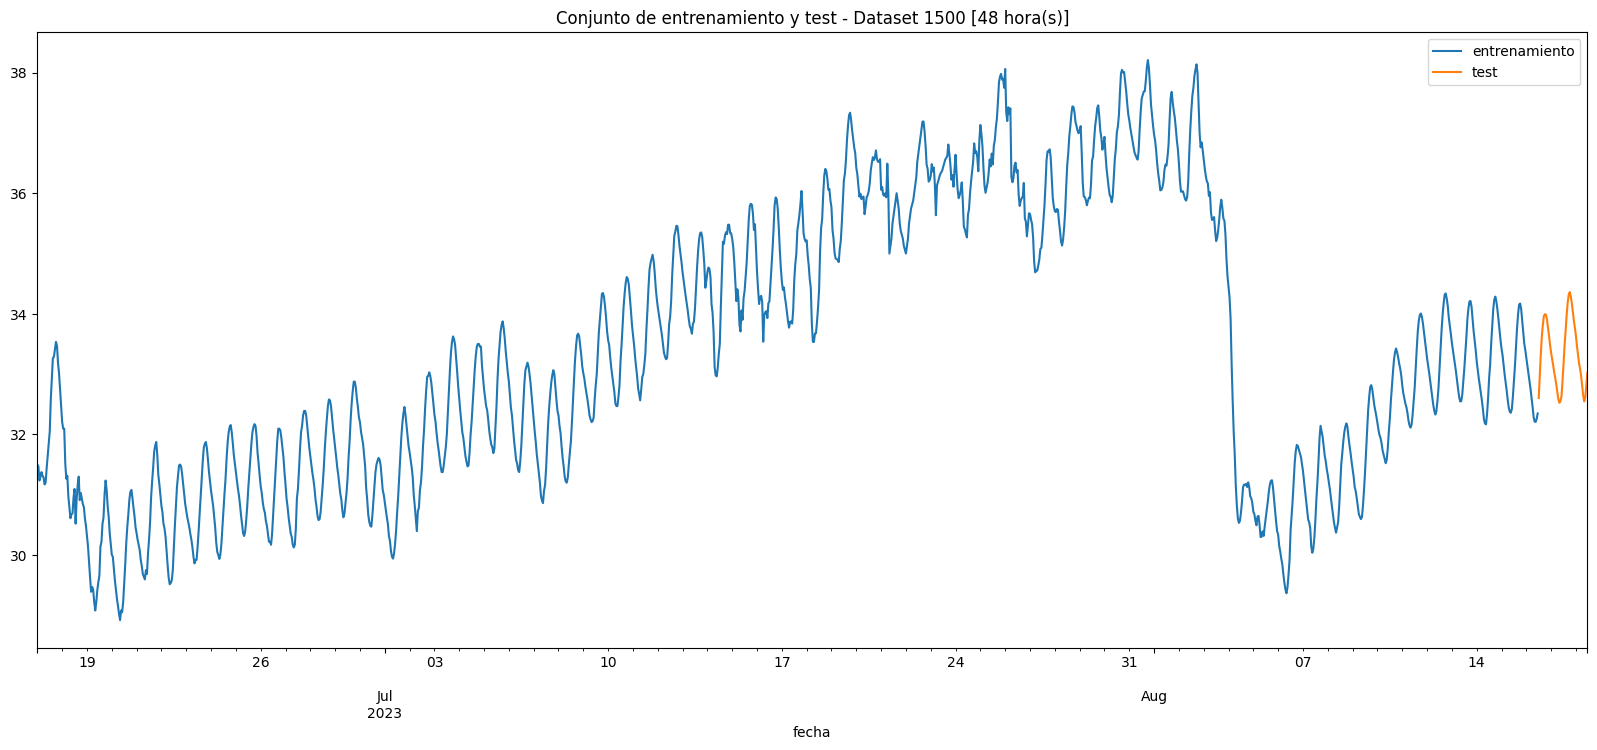

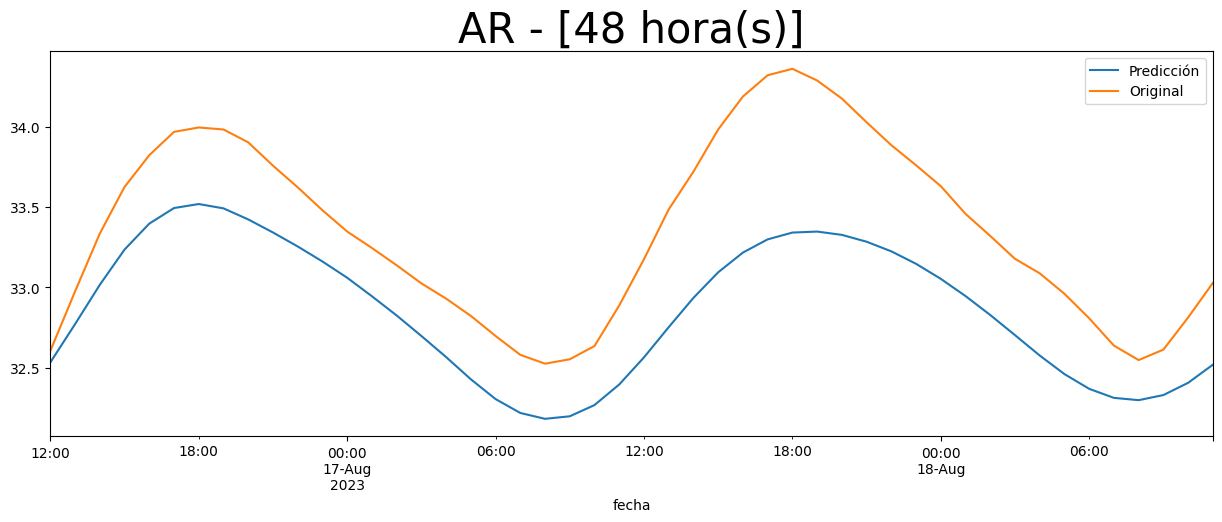

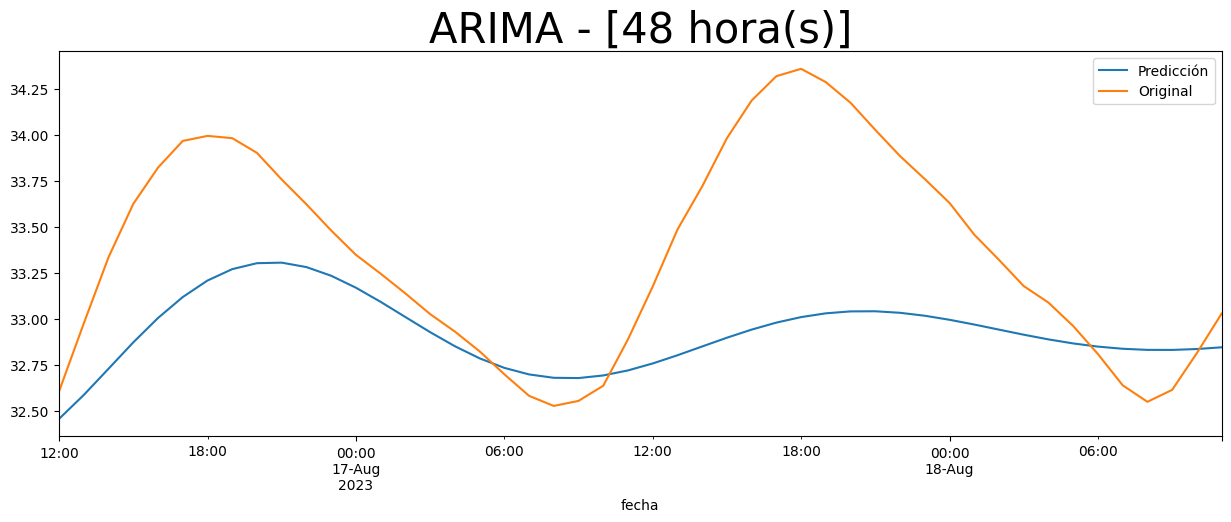

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


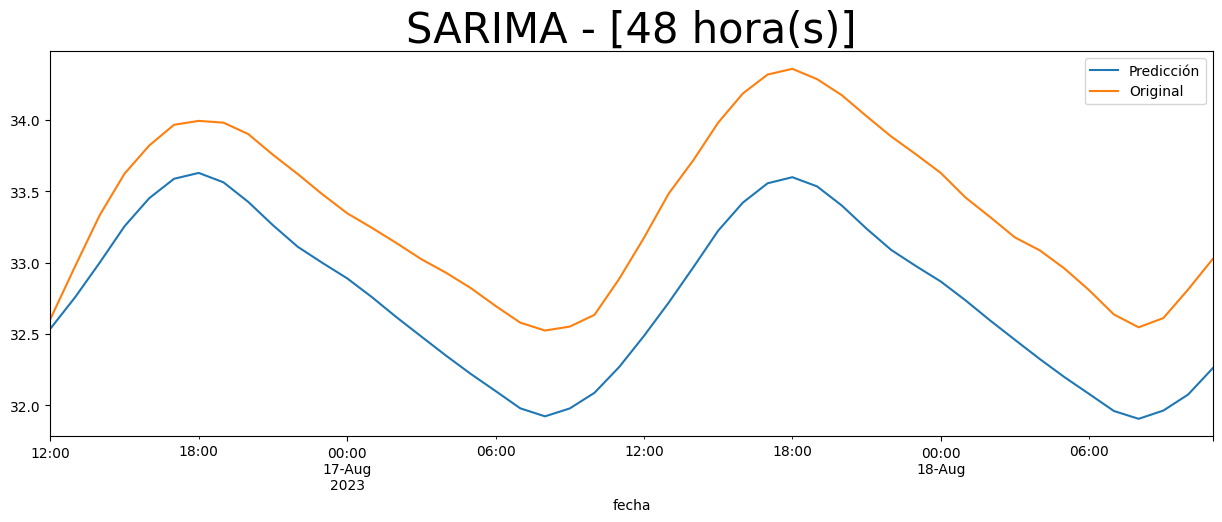

Fechas train : 2023-06-17 00:00:00 --- 2023-08-13 11:00:00  (n=1380)
Fechas test  : 2023-08-13 12:00:00 --- 2023-08-18 11:00:00  (n=120)


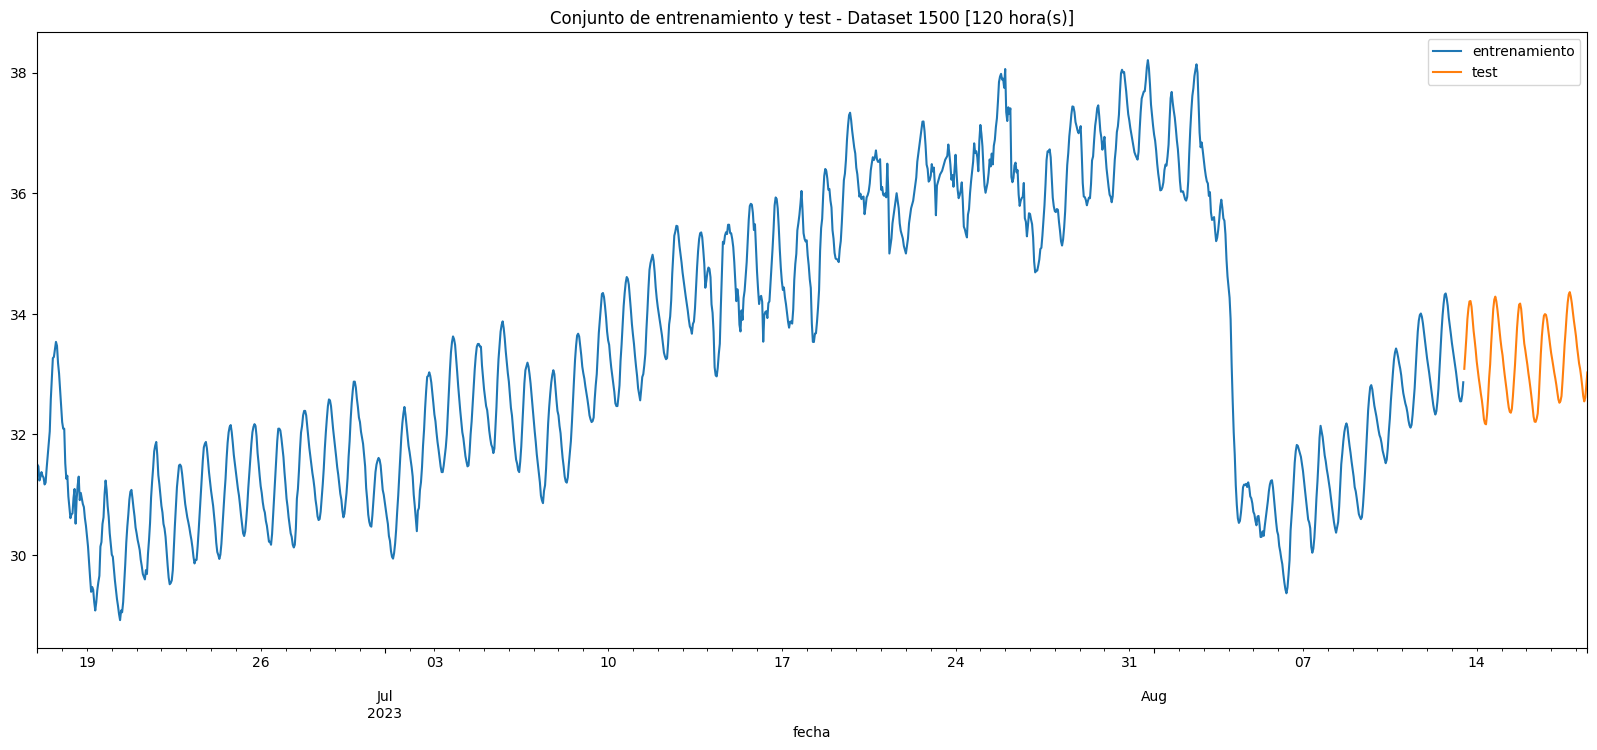

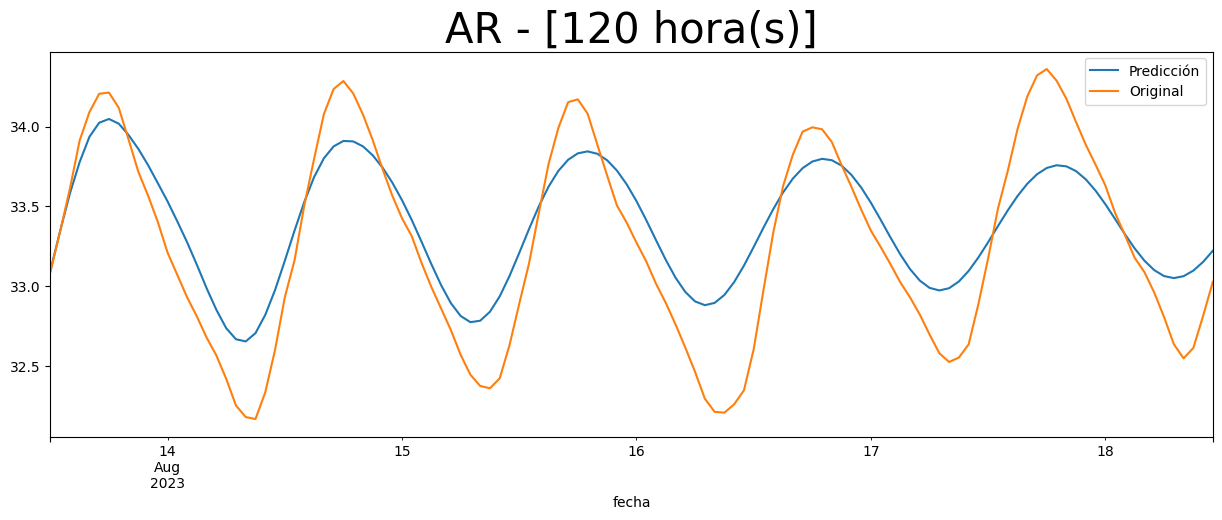

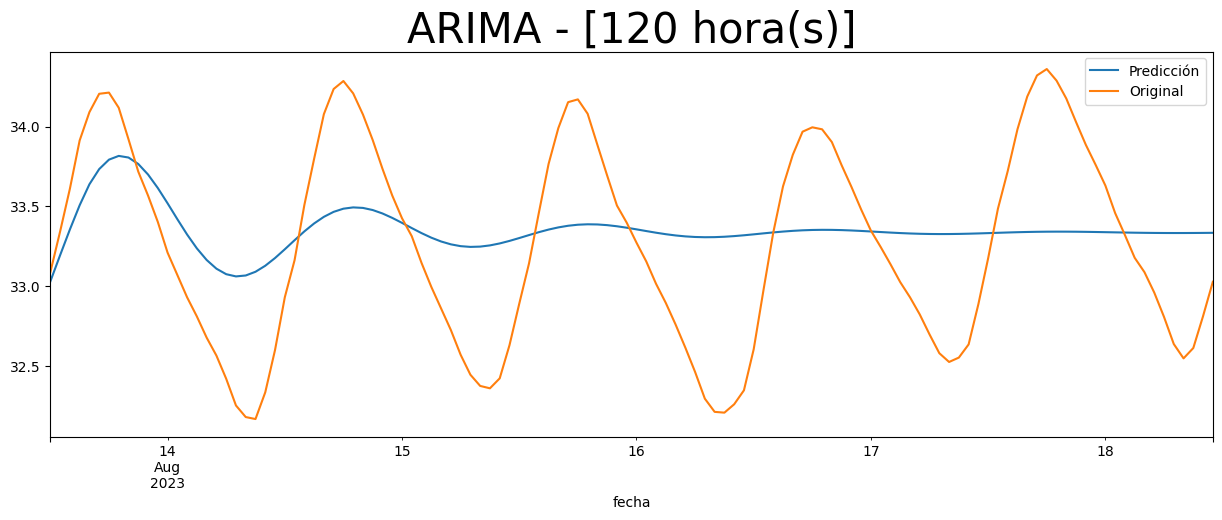

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


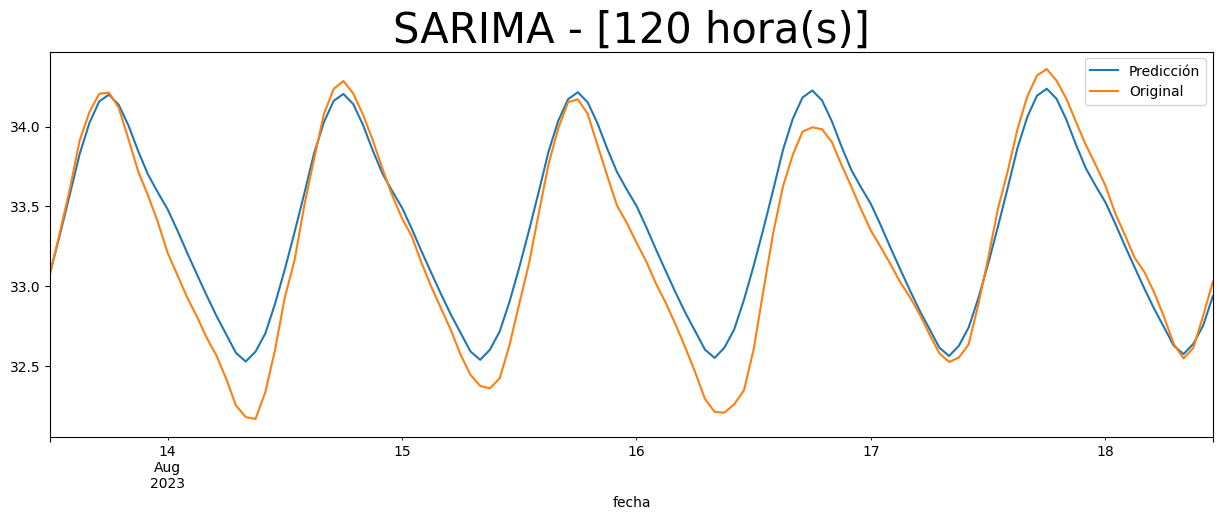

Fechas train : 2023-06-17 00:00:00 --- 2023-08-08 11:00:00  (n=1260)
Fechas test  : 2023-08-08 12:00:00 --- 2023-08-18 11:00:00  (n=240)


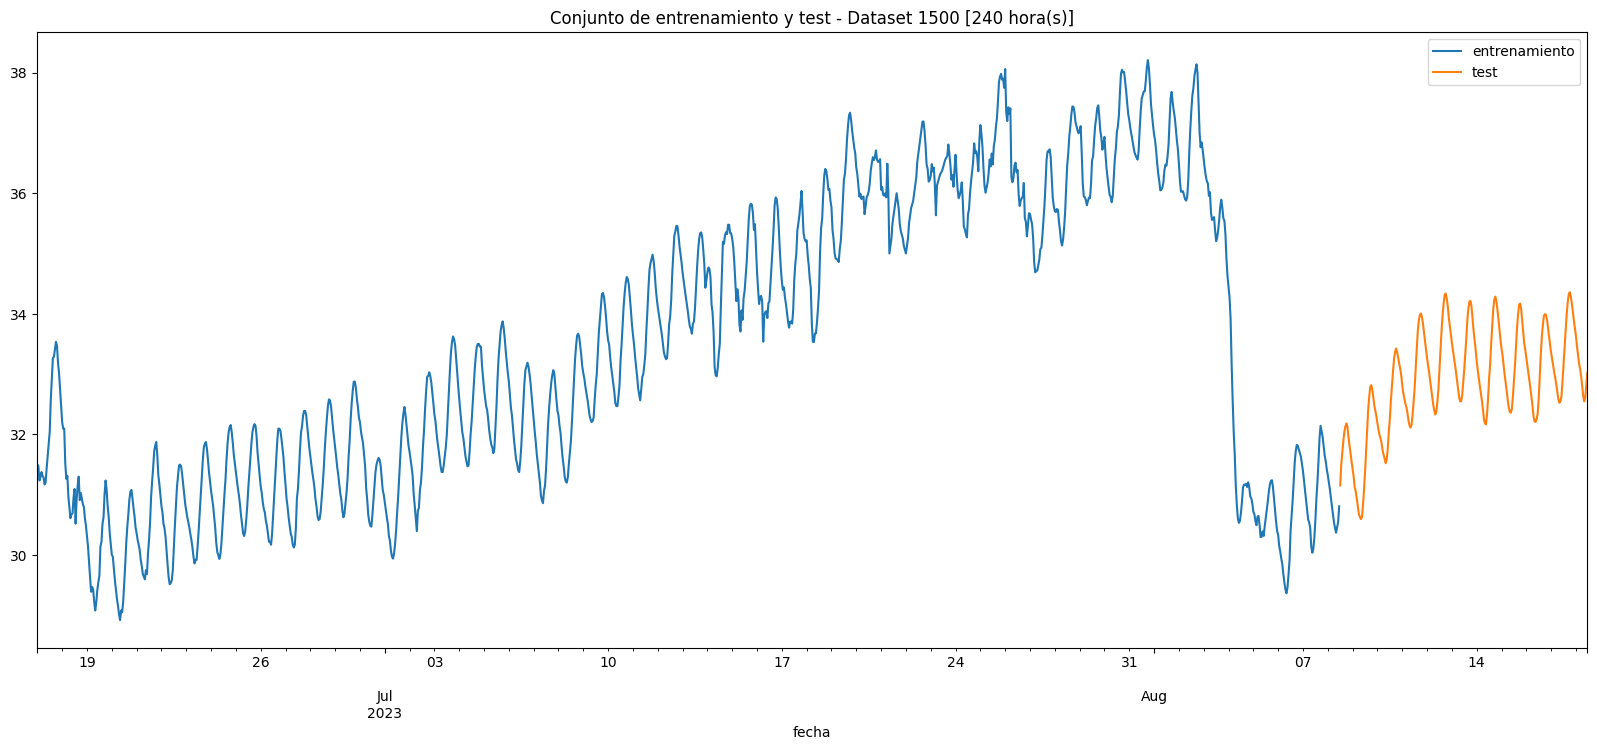

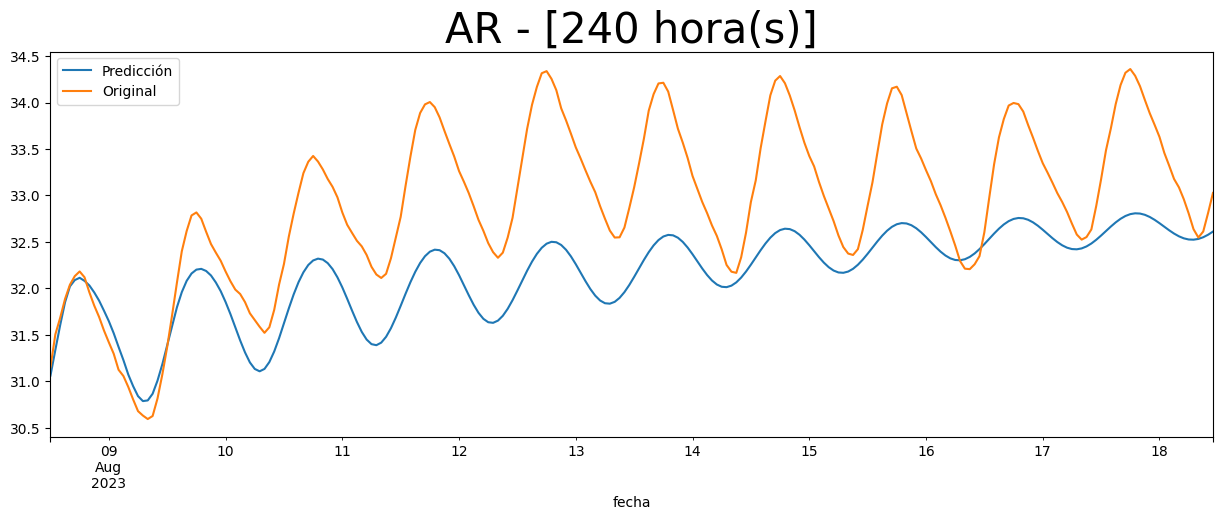

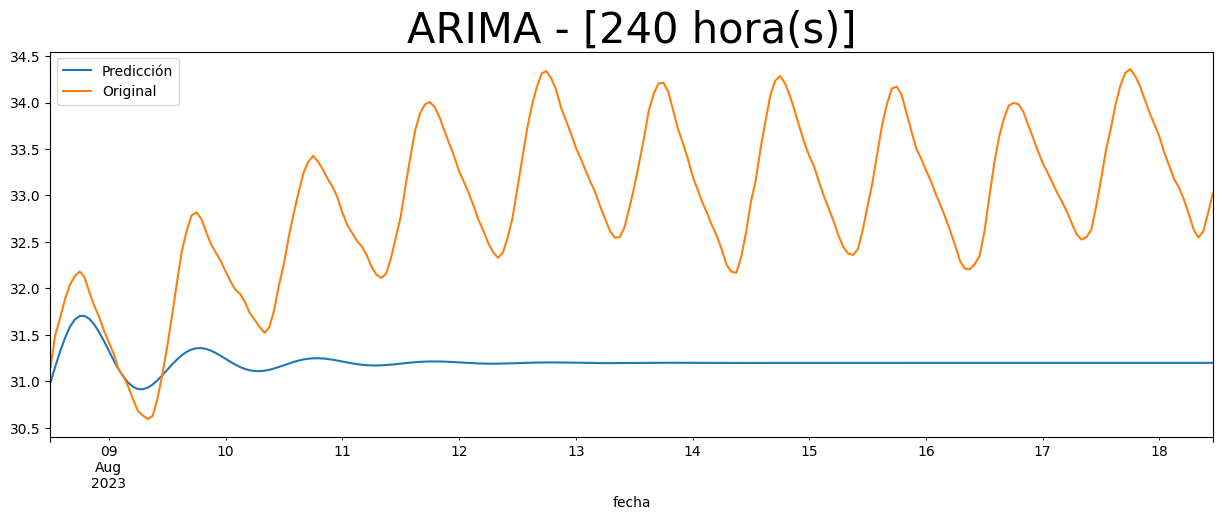

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


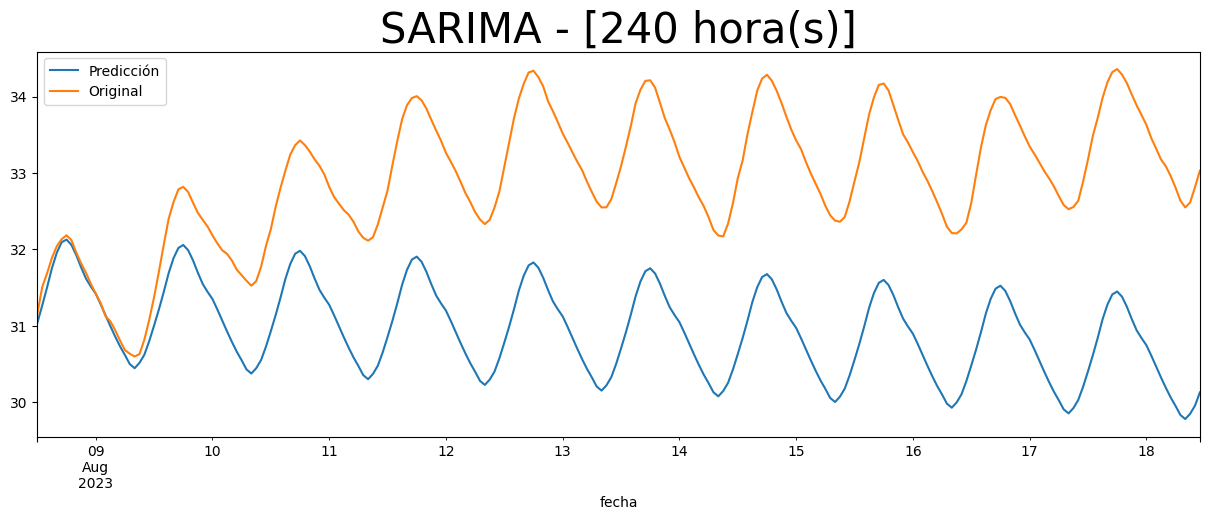

Fechas train : 2023-06-17 00:00:00 --- 2023-09-08 00:00:00  (n=1993)
Fechas test  : 2023-09-08 01:00:00 --- 2023-09-13 00:00:00  (n=120)


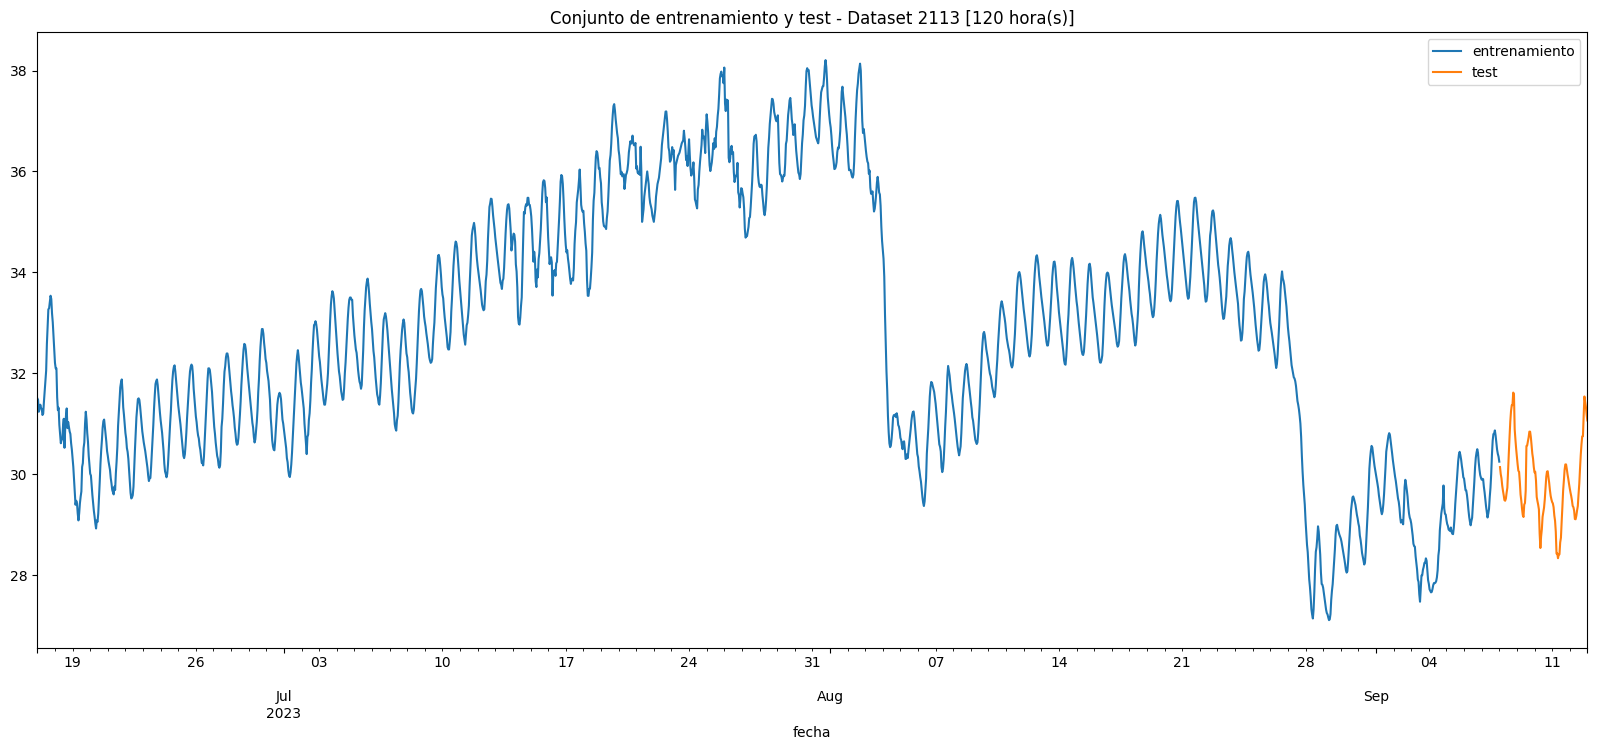

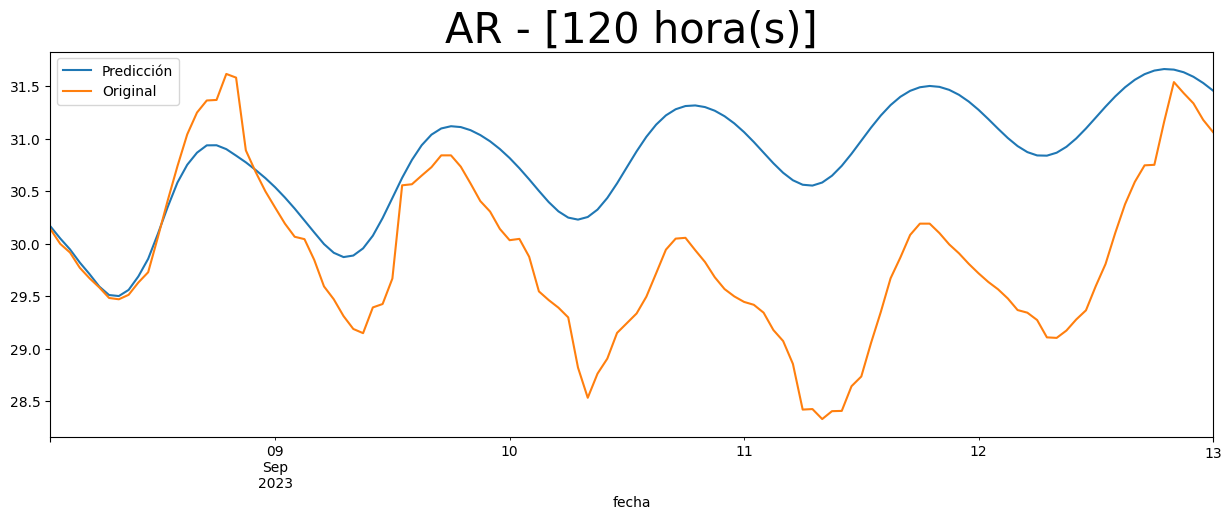

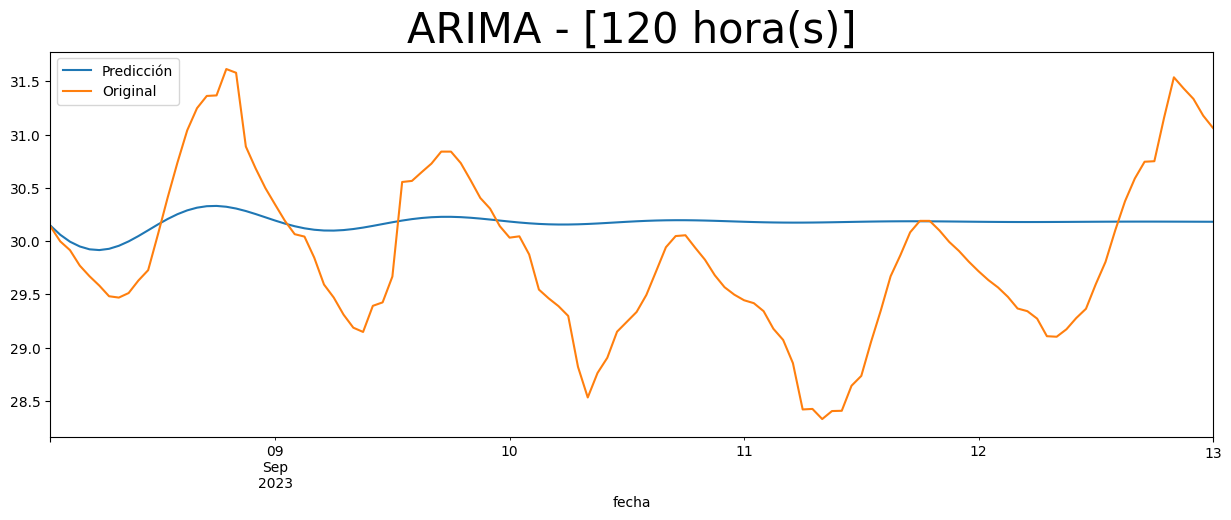

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


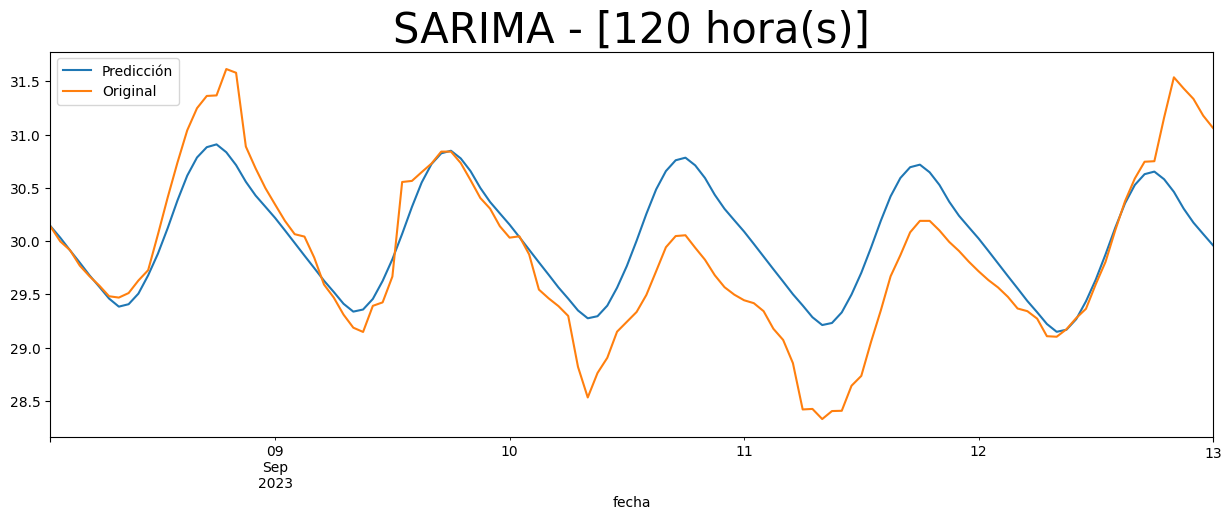

Fechas train : 2023-06-17 00:00:00 --- 2023-08-27 08:00:00  (n=1713)
Fechas test  : 2023-08-27 09:00:00 --- 2023-09-13 00:00:00  (n=400)


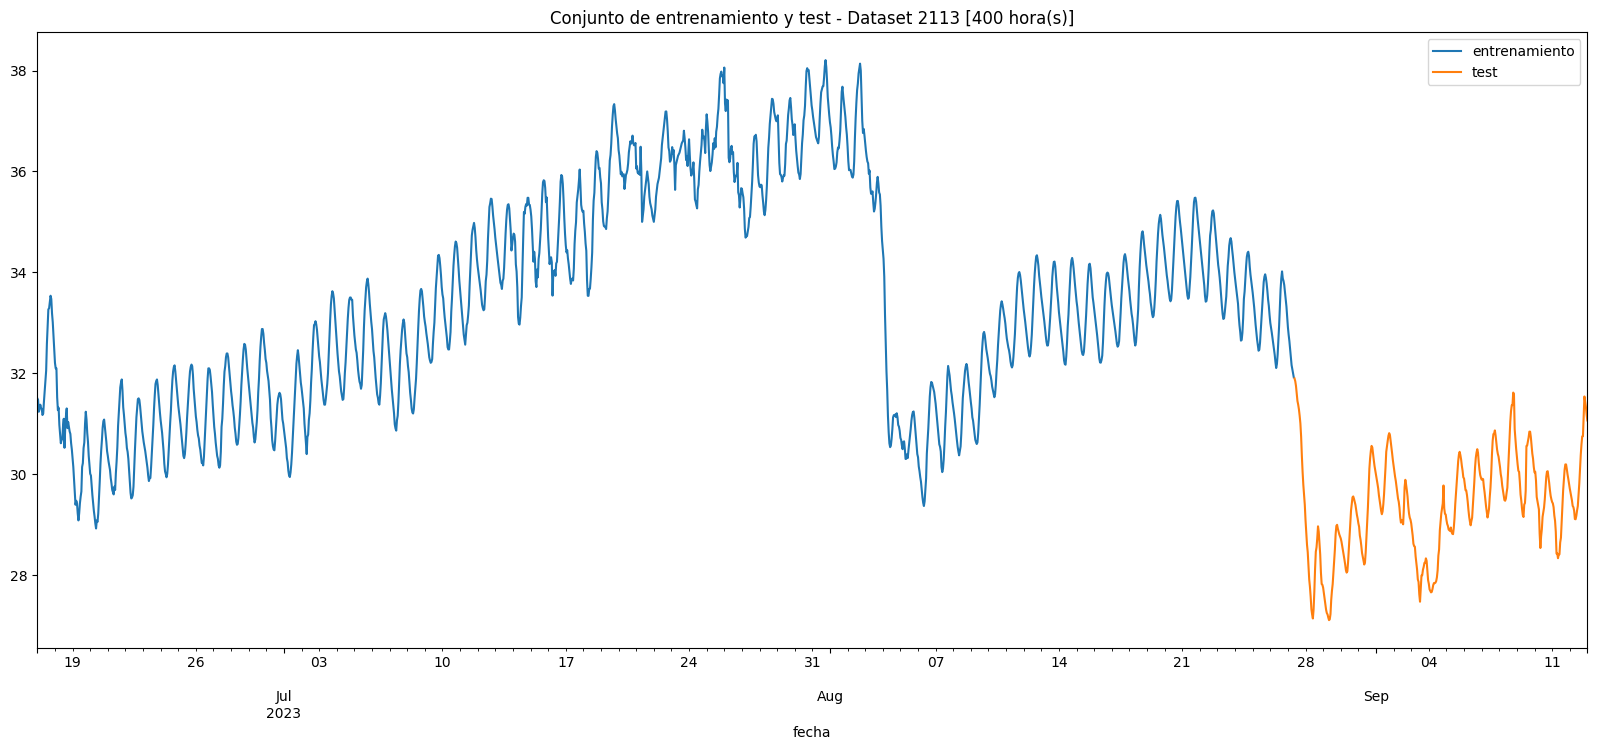

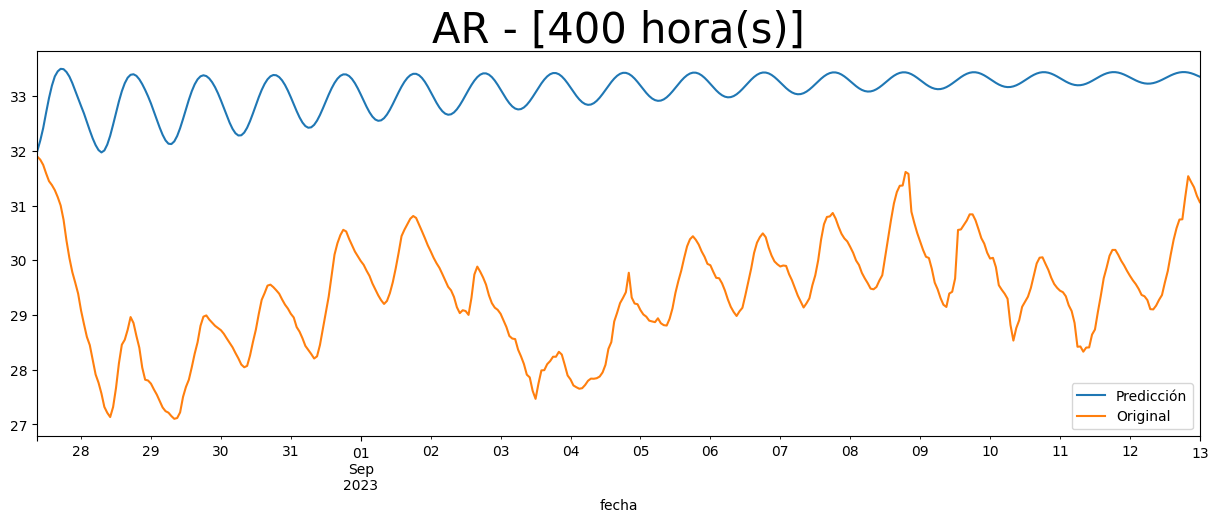

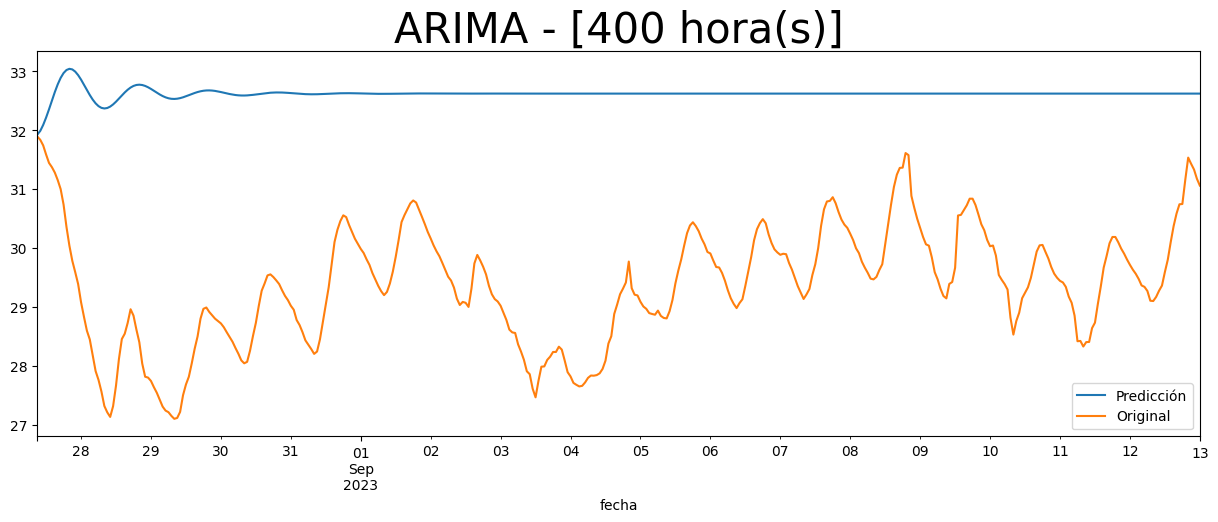

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


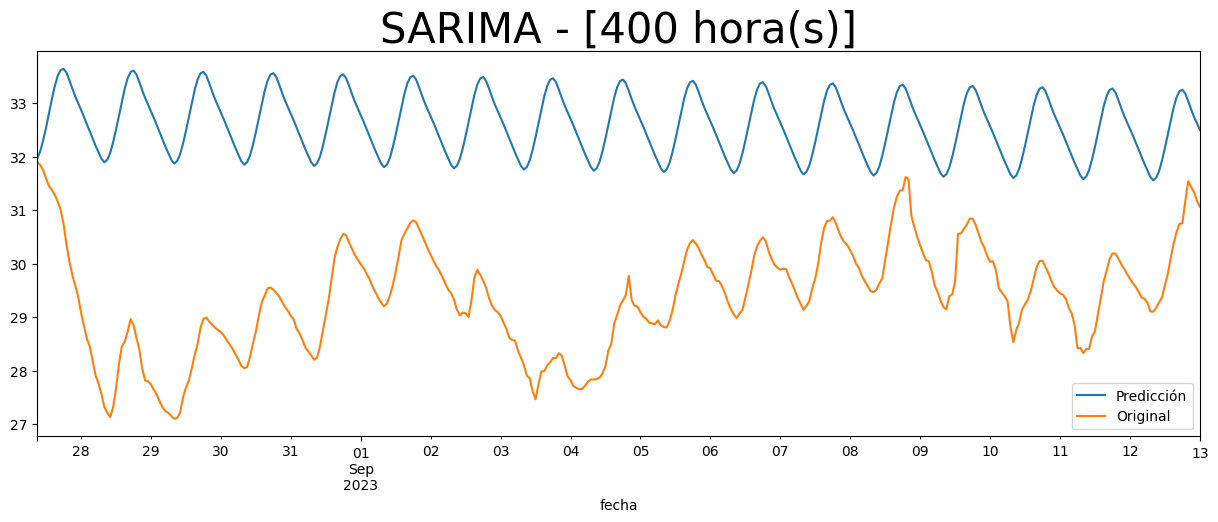

Fechas train : 2023-06-17 00:00:00 --- 2023-08-26 12:00:00  (n=1693)
Fechas test  : 2023-08-26 13:00:00 --- 2023-09-13 00:00:00  (n=420)


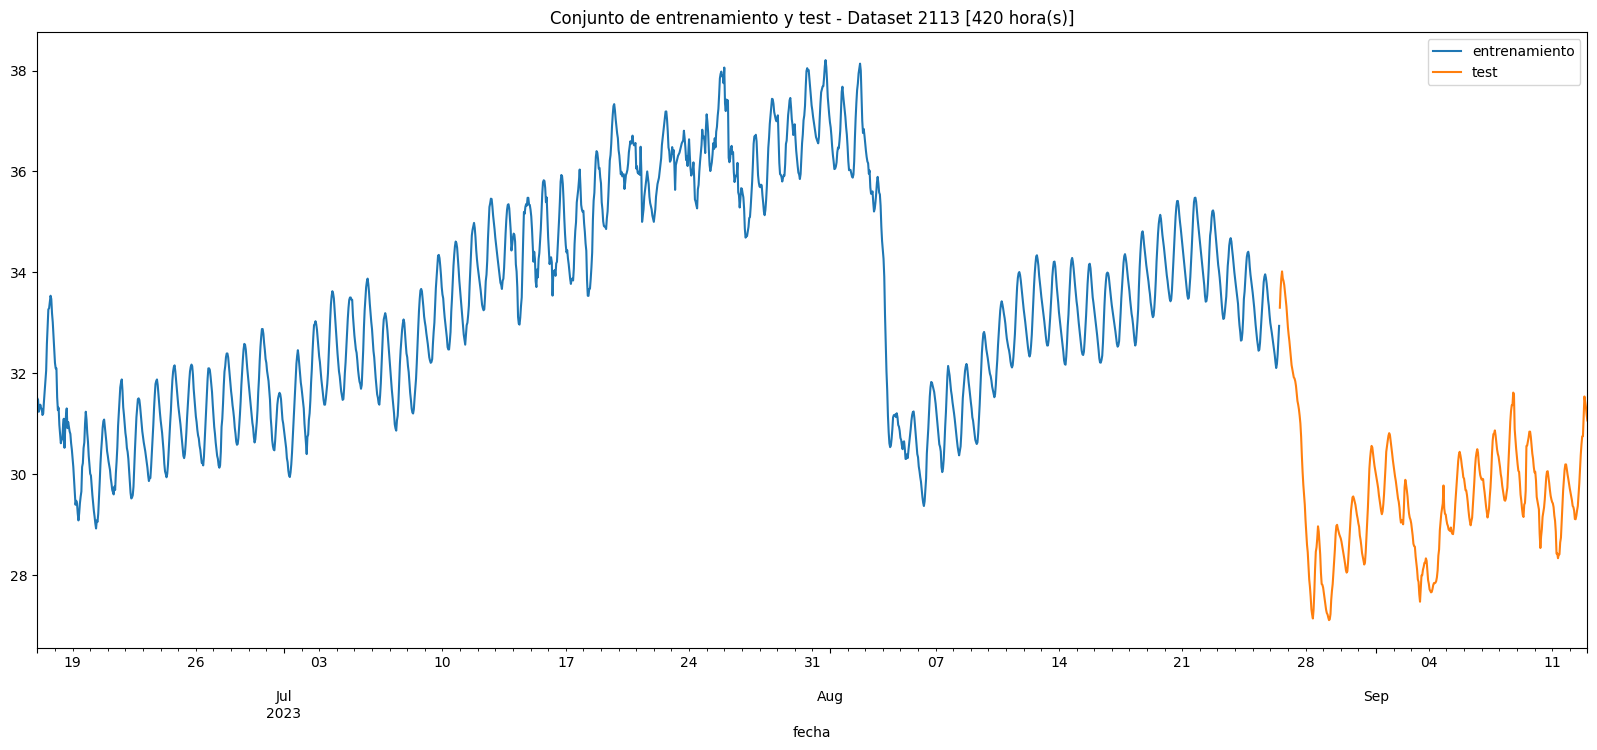

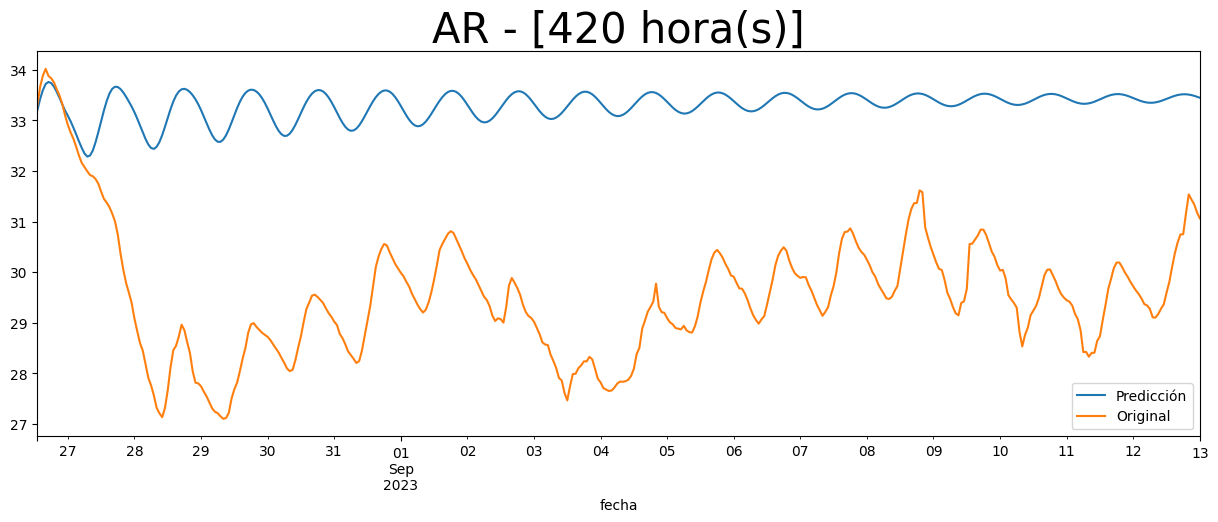

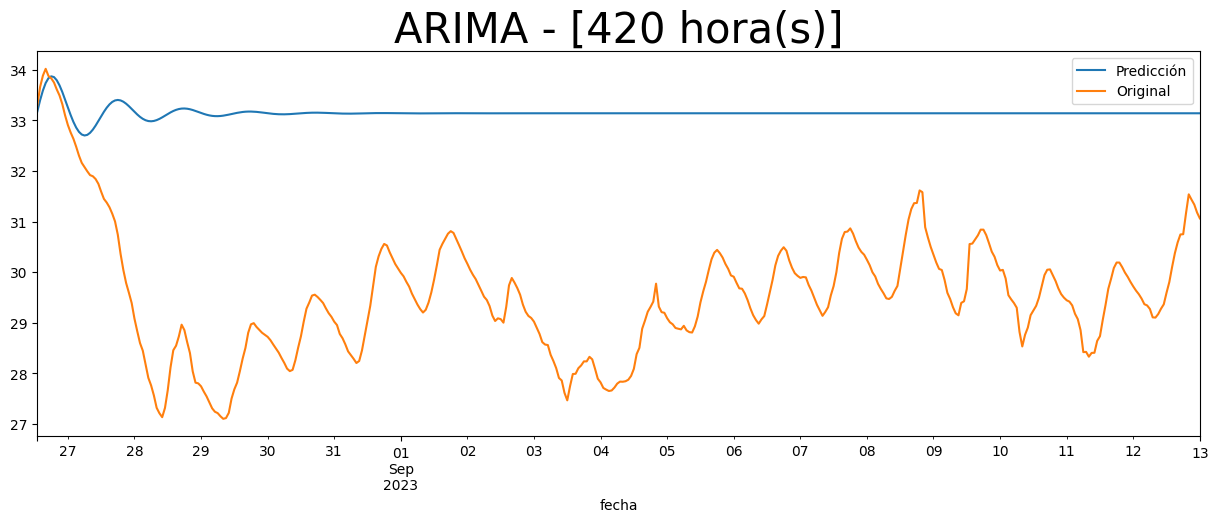

c:\Users\Vir\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


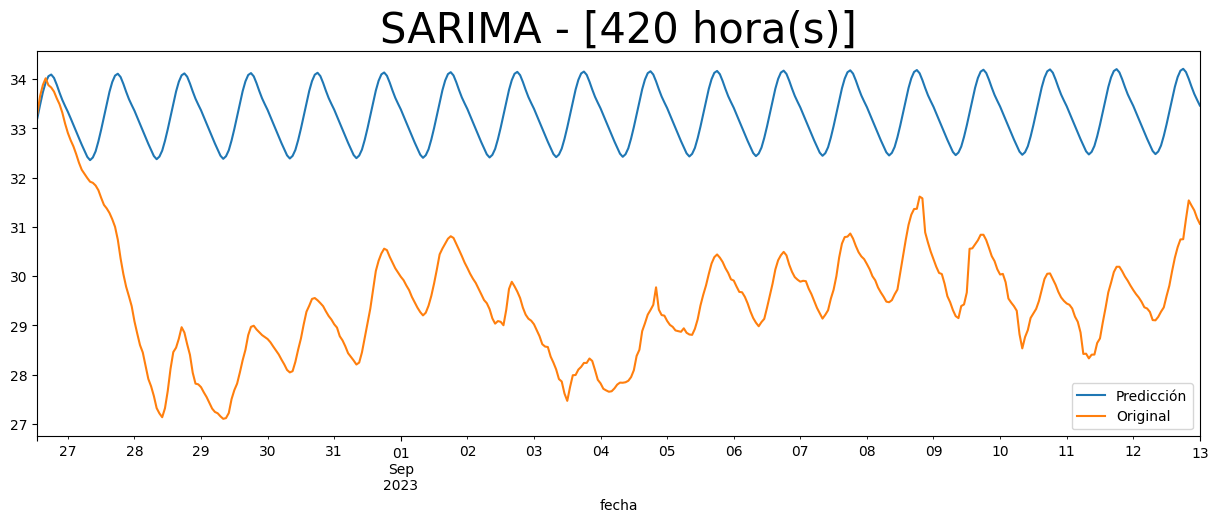

In [12]:
# DATASET 1

for hor in HORIZONTES_1_2:
    datos_train, datos_test = separar_train_test(datos, PRIMER_CONJUNTO, hor)
    resultados = ejecutar_modelos(datos_train, datos_test, resultados, 1, hor)

# DATASET 2

for hor in HORIZONTES_1_2:
    datos_train, datos_test = separar_train_test(datos, SEGUNDO_CONJUNTO, hor)
    resultados = ejecutar_modelos(datos_train, datos_test, resultados, 2, hor)

# DATASET 3

for hor in HORIZONTES_3:
    datos_train, datos_test = separar_train_test(datos, TERCER_CONJUNTO, hor)
    resultados = ejecutar_modelos(datos_train, datos_test, resultados, 3, hor)

In [13]:
resultados.reset_index(drop=True, inplace=True)
resultados

model  data  horizonte         r2        mse       mae
0       AR     1          1        NaN   0.001596  0.039948
1    ARIMA     1          1        NaN   0.008230  0.090722
2   SARIMA     1          1        NaN   0.000144  0.012006
3       AR     1          2  -0.935818   0.002205  0.045434
4    ARIMA     1          2  -1.968562   0.003381  0.044150
5   SARIMA     1          2 -14.519735   0.017678  0.131845
6       AR     1         12   0.319982   0.210188  0.432830
7    ARIMA     1         12  -1.156407   0.666527  0.785216
8   SARIMA     1         12   0.180829   0.253199  0.469855
9       AR     1         24   0.455973   0.166886  0.378063
10   ARIMA     1         24   0.356610   0.197366  0.368454
11  SARIMA     1         24   0.745284   0.078137  0.223159
12      AR     1         48  -0.135088   0.464862  0.570377
13   ARIMA     1         48   0.200873   0.327273  0.484723
14  SARIMA     1         48  -0.098898   0.450040  0.566760
15      AR     1        120  -1.141070   1.002723  0.906923
16   ARIMA     1        120  -2.482194   1.630809  1.121379
17  SARIMA     1        120  -0.356431   0.635255  0.713262
18      AR     1        240   0.093384   0.528795  0.596858
19   ARIMA     1        240  -0.636677   0.954612  0.791281
20  SARIMA     1        240   0.273392   0.423803  0.524838
21      AR     2          1        NaN   0.000006  0.002404
22   ARIMA     2          1        NaN   0.004220  0.064961
23  SARIMA     2          1        NaN   0.000002  0.001534
24      AR     2          2   0.262026   0.008528  0.091138
25   ARIMA     2          2  -2.934787   0.045471  0.203119
26  SARIMA     2          2   0.073859   0.010703  0.102678
27      AR     2         12   0.893638   0.011595  0.080544
28   ARIMA     2         12   0.043717   0.104247  0.237746
29  SARIMA     2         12   0.936522   0.006920  0.070656
30      AR     2         24   0.953721   0.015542  0.101188
31   ARIMA     2         24   0.639399   0.121098  0.301814
32  SARIMA     2         24   0.975356   0.008276  0.083863
33      AR     2         48   0.049843   0.294485  0.496783
34   ARIMA     2         48  -0.246937   0.386467  0.479782
35  SARIMA     2         48  -0.268278   0.393081  0.603964
36      AR     2        120   0.732925   0.103808  0.269157
37   ARIMA     2        120   0.184697   0.316895  0.484976
38  SARIMA     2        120   0.908252   0.035661  0.150658
39      AR     2        240  -0.152326   0.838661  0.778244
40   ARIMA     2        240  -3.962184   3.611470  1.713553
41  SARIMA     2        240  -5.280515   4.570949  1.970202
42      AR     3        120  -1.446242   1.415613  0.979200
43   ARIMA     3        120  -0.099513   0.636276  0.656344
44  SARIMA     3        120   0.571144   0.248174  0.373662
45      AR     3        400 -13.554212  14.710088  3.736541
46   ARIMA     3        400 -10.486546  11.609568  3.254069
47  SARIMA     3        400 -10.095808  11.214645  3.217645
48      AR     3        420  -8.688662  15.515271  3.755852
49   ARIMA     3        420  -8.059346  14.507494  3.608019
50  SARIMA     3        420  -8.601000  15.374890  3.751400

In [14]:
resultados.to_excel('resultados.xlsx', sheet_name='Experimentos_1',index=False)


In [15]:
df = pd.DataFrame(resultados)
df = df.round(2)
latex_code = df.to_latex(index=False, float_format="%.2f")

In [16]:
print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
model & data & horizonte & r2 & mse & mae \\
\midrule
AR & 1 & 1 & NaN & 0.00 & 0.04 \\
ARIMA & 1 & 1 & NaN & 0.01 & 0.09 \\
SARIMA & 1 & 1 & NaN & 0.00 & 0.01 \\
AR & 1 & 2 & -0.94 & 0.00 & 0.05 \\
ARIMA & 1 & 2 & -1.97 & 0.00 & 0.04 \\
SARIMA & 1 & 2 & -14.52 & 0.02 & 0.13 \\
AR & 1 & 12 & 0.32 & 0.21 & 0.43 \\
ARIMA & 1 & 12 & -1.16 & 0.67 & 0.79 \\
SARIMA & 1 & 12 & 0.18 & 0.25 & 0.47 \\
AR & 1 & 24 & 0.46 & 0.17 & 0.38 \\
ARIMA & 1 & 24 & 0.36 & 0.20 & 0.37 \\
SARIMA & 1 & 24 & 0.75 & 0.08 & 0.22 \\
AR & 1 & 48 & -0.14 & 0.46 & 0.57 \\
ARIMA & 1 & 48 & 0.20 & 0.33 & 0.48 \\
SARIMA & 1 & 48 & -0.10 & 0.45 & 0.57 \\
AR & 1 & 120 & -1.14 & 1.00 & 0.91 \\
ARIMA & 1 & 120 & -2.48 & 1.63 & 1.12 \\
SARIMA & 1 & 120 & -0.36 & 0.64 & 0.71 \\
AR & 1 & 240 & 0.09 & 0.53 & 0.60 \\
ARIMA & 1 & 240 & -0.64 & 0.95 & 0.79 \\
SARIMA & 1 & 240 & 0.27 & 0.42 & 0.52 \\
AR & 2 & 1 & NaN & 0.00 & 0.00 \\
ARIMA & 2 & 1 & NaN & 0.00 & 0.06 \\
SARIMA & 2 & 1 & NaN & 0.00 &